# Module 2: More on AR(1) Processes and Non-Stationarity tests

In this module, we will continue studying a popular ARMA($p$,$q$) process, the AR($1$) process. Specifically, we will simulate an AR($1$), estimate it via OLS, and study its asymptotic distribution. We will also explore questions and solutions to practice exercises. 

**Note:** If running the cell block right below gives the following warning: ``FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated...``, then this is an issue with the ``scipy`` library. Please update this library by running the following code in your Jupyter notebook:
``!pip install --upgrade scipy``

In [1]:
### Imports
from __future__ import print_function, division

import os
import sys
import math
import itertools
import pandas as pd
import numpy as np
import scipy
from scipy.stats import beta, chi2, t, norm

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.sandbox.regression import gmm
from statsmodels import tsa 
from statsmodels.tsa.vector_ar.hypothesis_test_results import CausalityTestResults
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from statsmodels.tsa.stattools import adfuller
from datetime import date, datetime, timedelta
import copy

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates

### Plotting and display options
np.set_printoptions(precision=3)
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

### Figure configuration
fsize = (10,7.5) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

### This allows plots to appear directly in the notebook
%matplotlib inline

In [2]:
# For the last exercise, make sure you have stastmodels version 0.9
import statsmodels
print(statsmodels.__version__)

0.9.0


**Digression:** For those interested, the function `hide_toggle` below can be used to hide cells in your Jupyter notebook. An application can be found [here](https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook)

In [3]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    ### Text shown on toggle link
    toggle_text = 'Toggle show/hide'  
    
    ### Target cell to control with toggle
    target_cell = this_cell 
    
    ### Bit of JS to permanently hide code in current cell (only when toggling next cell)
    js_hide_current = ''  

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

## Exercise 1: AR(1) simulation and OLS estimation

Write a function that **simulates** and then **estimates** an AR($1$) process with $\phi=0.75$ by OLS. 

**Hint:** Use the functions you wrote in **module 1**, or make use of the following `statsmodels` functions:
* `sm.tsa.arma_generate_sample` (more efficient than our own code; for repeated simulations this will be much faster)
* `sm.OLS`

**Solution to Exercise 1:** 
Given you already played with your "brute force" questions, for now, we will use the `statsmodels` functions by writing a function that both simulates and estimates via OLS an AR($1$) process. 

Our function will not be general enough and enable us to draw errors (i.e. $\epsilon$'s) from any distribution, other than the standard Gaussian. A useful exercise is to extend the function below to allow for this.

In [4]:
def simulate_est_ar1_ols(ar1_coef, nsample, summary=0):
    """AR(1) simulation and estimation wrapper"""
    ### Params for statsmodels.tsa
    ar = np.r_[1, -ar1_coef] # add zero-lag and negate
    ma = [1]  # add zero-lag
    
    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.arma_generate_sample.html
    ar_data = sm.tsa.arma_generate_sample(ar, ma, nsample) 
    
    ### estimate (include a constant)
    y = ar_data[1:]
    X = sm.add_constant(ar_data[:-1])
    
    ### Consider the option that shows the summary of the model estimation:
    if summary:
        ar1_model = sm.OLS(y,X).fit()
        print(ar1_model.summary())
    
    beta_hat = sm.OLS(y,X).fit().params
    return beta_hat

We will create a list `nsample_T ` that contains an increasing sequence of sample sizes $T$:

In [5]:
### Seed the random number generator
np.random.seed(10)

## Set parameter 'phi' and sample sizes T
phi1 = 0.75 
nsample_T = [100, 250, 1000, 10000, 10000, 25000]

In [6]:
for T in nsample_T:
    print('AR(1) parameter estimates (mu, phi) for T=' + str(T) + ':', 
          simulate_est_ar1_ols(phi1, nsample=T), '\n')

AR(1) parameter estimates (mu, phi) for T=100: [0.103 0.652] 

AR(1) parameter estimates (mu, phi) for T=250: [0.068 0.706] 

AR(1) parameter estimates (mu, phi) for T=1000: [-0.023  0.773] 

AR(1) parameter estimates (mu, phi) for T=10000: [0.006 0.745] 

AR(1) parameter estimates (mu, phi) for T=10000: [-0.011  0.748] 

AR(1) parameter estimates (mu, phi) for T=25000: [0.005 0.743] 



## Exercise 2: AR(1) OLS Distribution 

**Goal:** <u>First</u>, plot the distribution of the OLS estimator $\widehat{\phi}$ over repeated simulations (or "paths") for each of the sample sizes $T$ from **Exercise 1**. Let's simulate **2,000** realizations. 

<u>Then</u>, plot the distribution of $\sqrt{T}(\hat{\phi} - \phi)$ and compare it with that of the theoretical normal distribution <br> 
*See:* `mpl.mlab.normpdf`

**Solution to Exercise 2 - Part 1:**

In [7]:
def plot_ar1_ols(ar1_coef, nsample_T, Nsims=100, ax=None):
    ### List containing all regression results
    ar1_results = [simulate_est_ar1_ols(ar1_coef, nsample_T) for _ in range(Nsims)]
    
    ### Estimated AR(1) coefficient array
    ar1_hats = np.array([b[-1] for b in ar1_results])
    ar1_label = "Mean$(\widehat\phi)$ = {:.3f}\nStdDev$(\widehat\phi)$ = {:.3f}"\
                .format(np.mean(ar1_hats),np.std(ar1_hats))        
    ### Set figure
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,20))
    
    ax.hist(ar1_hats, bins=50, density=True, edgecolor = "black", label=ar1_label)
     
    ### Add the true value
    ymin, ymax = ax.get_ylim()
    ax.plot((ar1_coef, ar1_coef), (ymin, ymax), 'r--', linewidth=2)

In [8]:
### Set the AR(1) coefficient
phi1 = 0.75

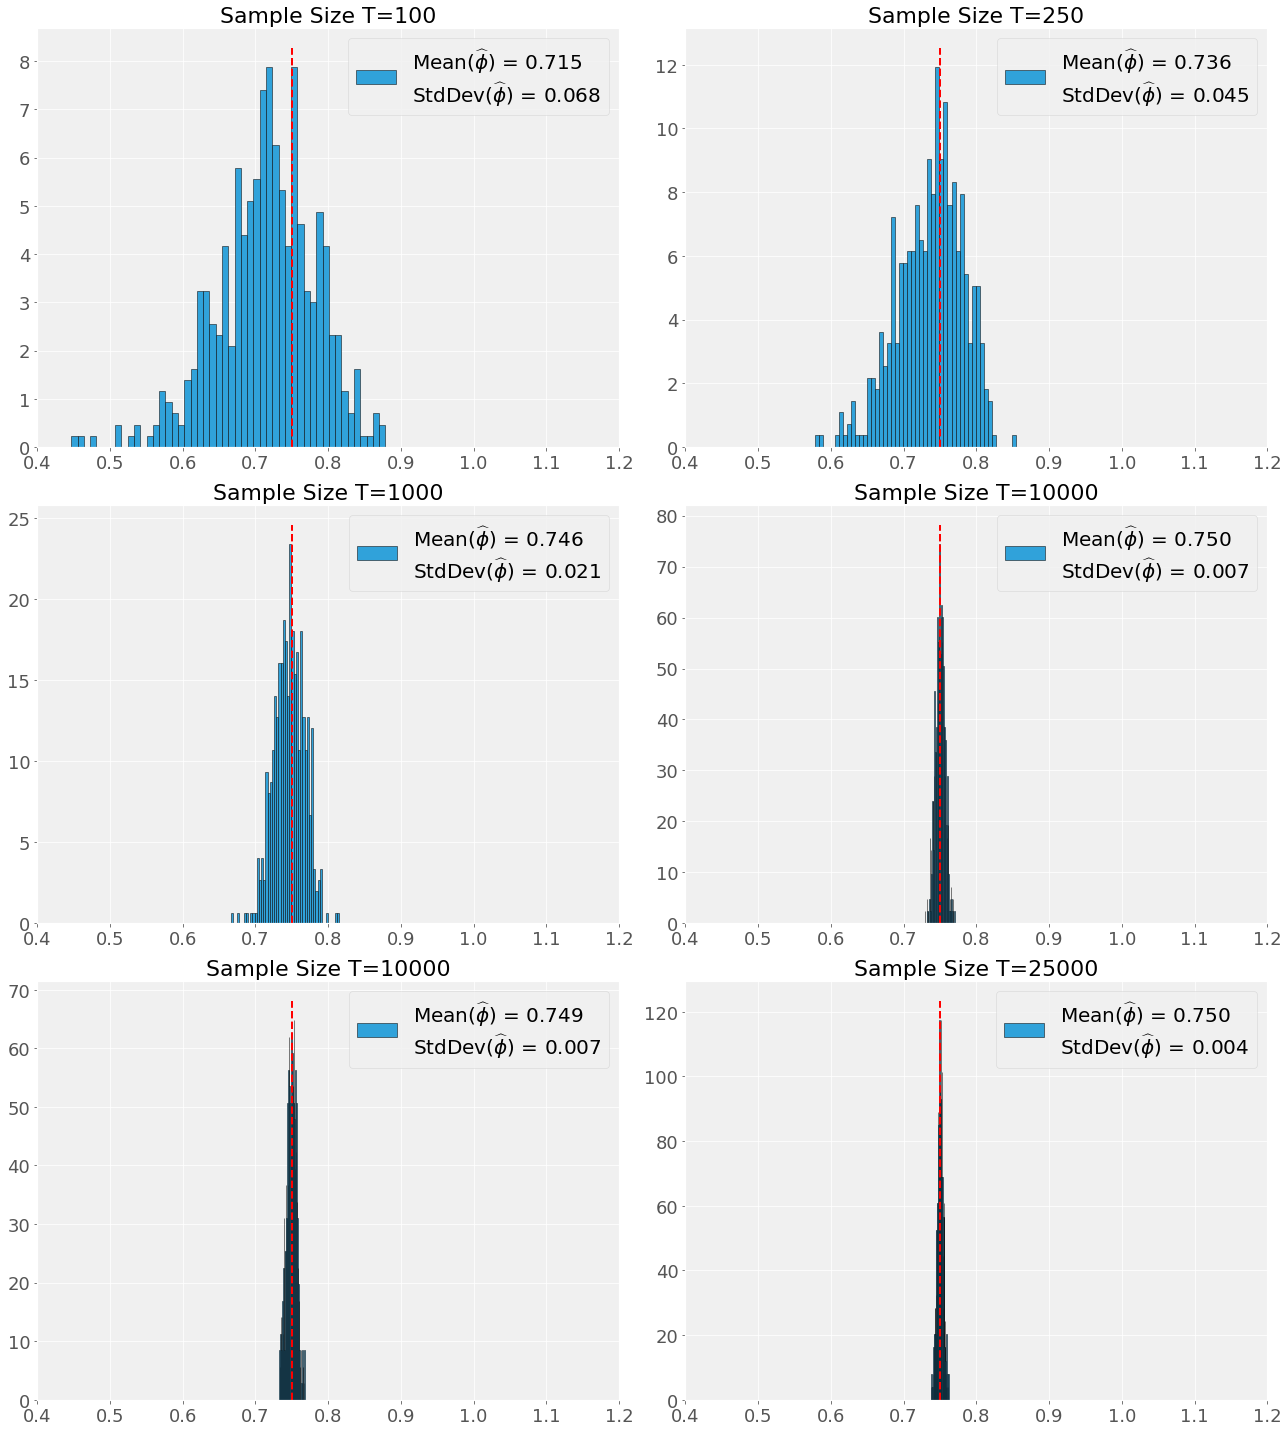

In [9]:
### Test out of the function with Nsims = 500 (i.e. # of simulations)
np.random.seed(123)
Nsims = 500
xlims = [0.4, 1.2]

### Set up figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,20))
for idx, nsample in enumerate([100, 250, 1000, 10000, 10000, 25000]):
    idx_r, idx_c = idx//2, np.mod(idx,2) 
    ax = axes[idx_r, idx_c]
    
    ### plot
    plot_ar1_ols(phi1, nsample, Nsims=Nsims, ax=ax)
    
    ### Same x axis
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_title('Sample Size T=%d' % nsample, fontsize=22)
    ax.legend(fontsize=20)   

fig.tight_layout()

### **Solution to Exercise 2 - Part 2:**

We now plot the asymptotic distribution $\sqrt{T}(\hat{\phi} - \phi)$ with  $\phi=0.75$

In [10]:
def plot_ar1_ols_dist(ar1_coef, nsample, Nsims=100, ax=None):
    ### List containing all regression results
    ar1_results = [simulate_est_ar1_ols(ar1_coef, nsample) for _ in range(Nsims)]
    
    ### Estimated AR(1) coefficient array
    ar1_hats = np.array([b[-1] for b in ar1_results])
    ar1_hats_sqrT = np.sqrt(nsample)*(ar1_hats - ar1_coef) # sqrt(T)* (ar1_hat - ar1_true)
    ar1_label = "Mean$(\widehat\phi)$ = {:.3f}\nStdDev$(\widehat\phi)$ = {:.3f}"\
                .format(np.mean(ar1_hats),np.std(ar1_hats)) 
    
    ### Set figure
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,20))
    
    ### Normalized: see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html
    ax.hist(ar1_hats_sqrT, bins=50, density=True, edgecolor = "black" , label=ar1_label) 
    
    ### Add normal distribution (in orange)
    xmin, xmax = ax.get_xlim()
    mu = 0
    sigma = np.sqrt(1 - ar1_coef**2)
    x = np.linspace(-3,3, 100)
    
    ar1_label = "E$(\phi)$ = {:.3f}\n$\sigma(\phi)$ = {:.3f}"\
                .format(ar1_coef, sigma*(nsample**-0.5))
    ax.plot(x, scipy.stats.norm.pdf(x, mu, sigma), 
            linewidth=3, color='xkcd:orange', label=ar1_label)
    ax.legend(fontsize=20)   

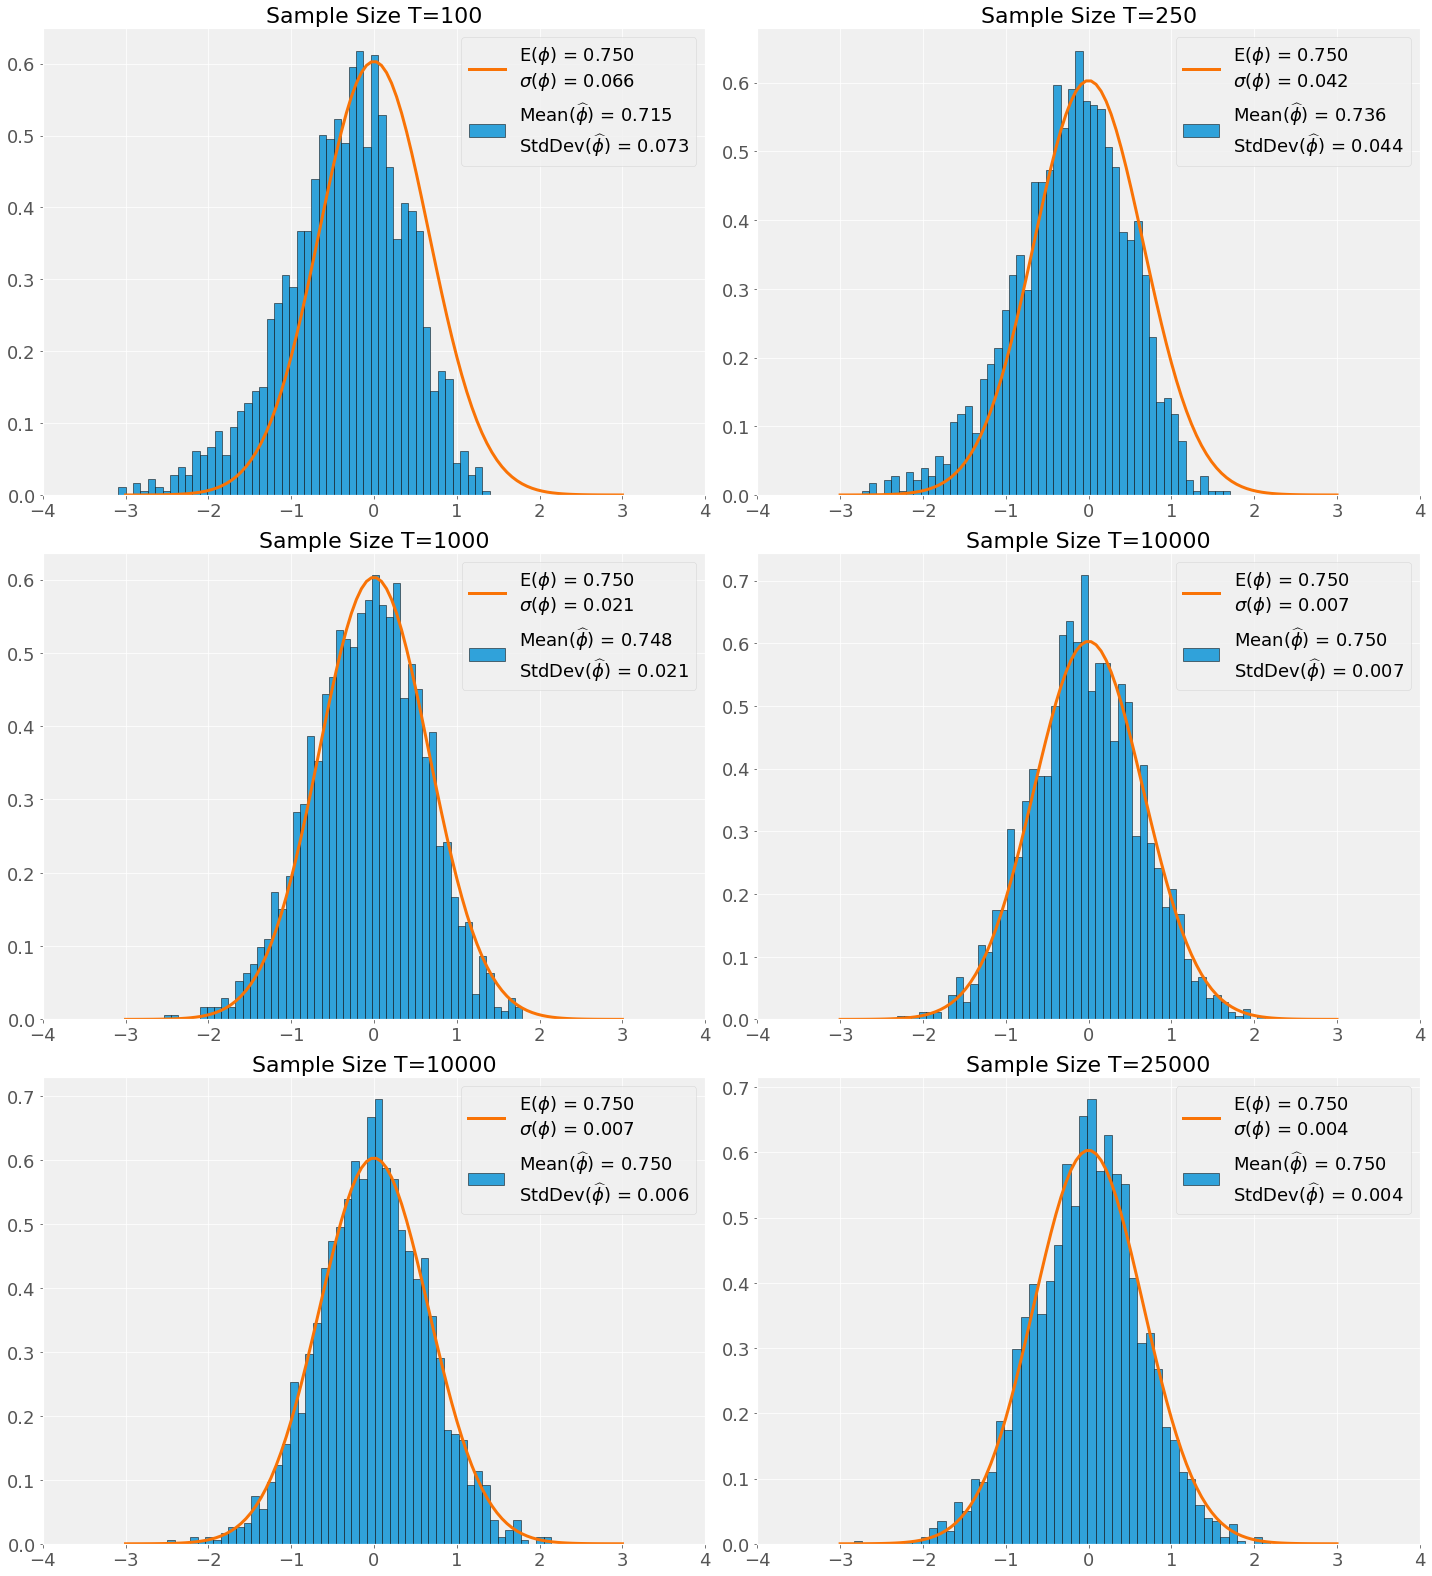

In [11]:
### Test out of the function: phi1 = 0.75, Nsims = 2000
np.random.seed(123)
phi1 = 0.75
Nsims = 2000
xlims = [-4, 4]
### Set up figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,22))
for idx, nsample in enumerate([100, 250, 1000, 10000, 10000, 25000]):
    idx_r,idx_c = idx//2, np.mod(idx,2) 
    ax = axes[idx_r,idx_c]
    plot_ar1_ols_dist(phi1, nsample, Nsims=Nsims, ax=ax)
    
    ### Same x axis
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_title('Sample Size T=%d' % nsample, fontsize=22)
    ax.legend(fontsize=18)   

fig.tight_layout()

## Exercise 3:
Assume that 
$$
x, \epsilon \sim i.i.d. N(0,1)
$$ 
and let $y = x + \epsilon$.  

Perform the following Monte Carlo simulation for $T=20, 50, 100, 500$. 

* **Step 1:** Draw $T$ observations of $x$ and $\epsilon$ and compute the implied $y$ for each observation.
* **Step 2:** Compute the OLS regression $y = \beta x + \epsilon$.
* **Step 3:** Repeat **Steps 1.** and **2.** 10,000 times and save the coefficient estimate $\widehat{\beta}$ in each regression. 
* **Step 4:** Plot the <u>histogram</u> of the distributions for the estimated $\widehat{\beta}$'s for $T=20,100,1000$
* **Step 5:** Compare the actual distributions of estimate $\widehat{\beta}$ from the simulations to the theoretical distributions.

**Note**: It is clear that $y \sim i.i.d. N(0,2)$

### Solution to Exercise 3:

To answer this question, we can start with some of the code from **module 1**. 

First, I will rewrite the "wrapper" for the `statsmodels` OLS regression estimation routine so it returns the parameter estimates and residuals in one function.

In [12]:
def _sm_calc_ols(y, x, addcon=True):
    """Wrapper for statsmodels OLS regression"""
    ### Add a constant if addcon==True=1
    if addcon:
        X = sm.add_constant(x) 
    else:
        X = x 
    ols_results = sm.OLS(y,X).fit()
    beta_hat = ols_results.params # beta_hat
    resids = ols_results.resid  # resids
    return beta_hat, resids, X

Second, I will write a function `monte_carlo_stats` that stores important summary statistics for each Monte Carlo simulation. 

This function requires that we transform our sample of $\widehat{\beta}$ estimates (for each $T$) into a pandas `Series` or `DataFrame`.

In [13]:
def monte_carlo_stats(np_coef, nsample_T, percentiles, dist_params):
    coef_desc_T = pd.DataFrame(np_coef).describe(percentiles=percentiles)
    if type(dist_params) is tuple:
        coef_desc_cols = "{}='({})'".format('T=' + str(nsample_T) + ', params', 
                                            ', '.join(str(p) for p in dist_params)) 
    else:
        coef_desc_cols = "{}='{}'".format('T=' + str(nsample_T) + ', param',''.join(str(dist_params))) 
    coef_desc_T.rename(columns={0: coef_desc_cols}, inplace=True)
    coef_desc_T.loc['count'] = coef_desc_T.loc['count'].apply('{:.0f}'.format)
    return coef_desc_T

Second, I will write a function `monte_carlo_sim` so it is flexible enough to allow for a general class of distributions for the random variables $x$ and $\epsilon$. 

In [14]:
def monte_carlo_sim(const=0, nsample_T=100, 
                    burnin=0, num_sims=1, 
                    dist='normal', params=(0,1)):
    """Simulate ARMA data
       :PARAM const: constant in the model [default: const=0]
       :PARAM nsample_T: nsample is the sample size [default: nsample=100]
       :PARAM burnin: burn-in samples [default: burnin=0]
       :PARAM num_sims: # of simulations [default: num_sims=1]
       :PARAM dist: 'str' object with distribution to draw from [default: dist='normal']
           Note: The 'str' dist must coincide exactly with the np.random function
                 --> See https://docs.scipy.org/doc/numpy/reference/routines.random.html
       :PARAM params: tuple with distributional parameters associated with 'dist'    
    """
    
    ### Total number of sample size
    nsample = nsample_T + burnin
    
    ### Draw x and eps from 'dist'
    if type(params) is tuple:
        x   = getattr(np.random, dist)(*params, (num_sims, nsample)) - const
        eps = getattr(np.random, dist)(*params, (num_sims, nsample)) - const
    else:
        x   = getattr(np.random, dist)(params, (num_sims, nsample)) - const
        eps = getattr(np.random, dist)(params, (num_sims, nsample)) - const   
    
    ### Compute [num_sims x (T + burnin)] array of y = x + eps values
    y = x + eps
    
    ### Call the '_sm_calc_ols' function on each simulated sample (i.e. row)
    ### Note: we only retrieve the estimated beta coefficient
    coef = [_sm_calc_ols(y[i,:], x[i,:])[0] for i in range(y.shape[0])]
    np_coef = np.asarray(coef)
    
    ### Extract intercept and beta coefficient
    intercept_hat = np_coef[:,0]
    beta_hat = np_coef[:,1]

    ### Print summary statistics (w/ detailed percentiles)
    percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    mc_stats = monte_carlo_stats(beta_hat, nsample_T, percentiles=percentiles, dist_params=params)
       
    return intercept_hat, beta_hat, mc_stats

In [15]:
### Test our function 'monte_carlo_sim':
### Application: x, eps ~ i.i.d. N(0,1) for T=100, simulations=5
_, beta_hat, mc_stats =  monte_carlo_sim(const=0, nsample_T=100, 
                                         burnin=0, num_sims=5, 
                                         dist='normal', params=(0,1))

### Summary Stats
print(mc_stats)

      T=100, params='(0, 1)'
count                      5
mean                   1.048
std                    0.128
min                    0.860
1%                     0.865
5%                     0.883
10%                    0.906
25%                    0.975
50%                    1.096
75%                    1.130
90%                    1.158
95%                    1.167
99%                    1.174
max                    1.176


The call above takes care of **Steps 1-3** for this problem. We now want to plot the histogram of the distributions for the $\widehat{\beta}$'s for $T=20,50,100,1000$:

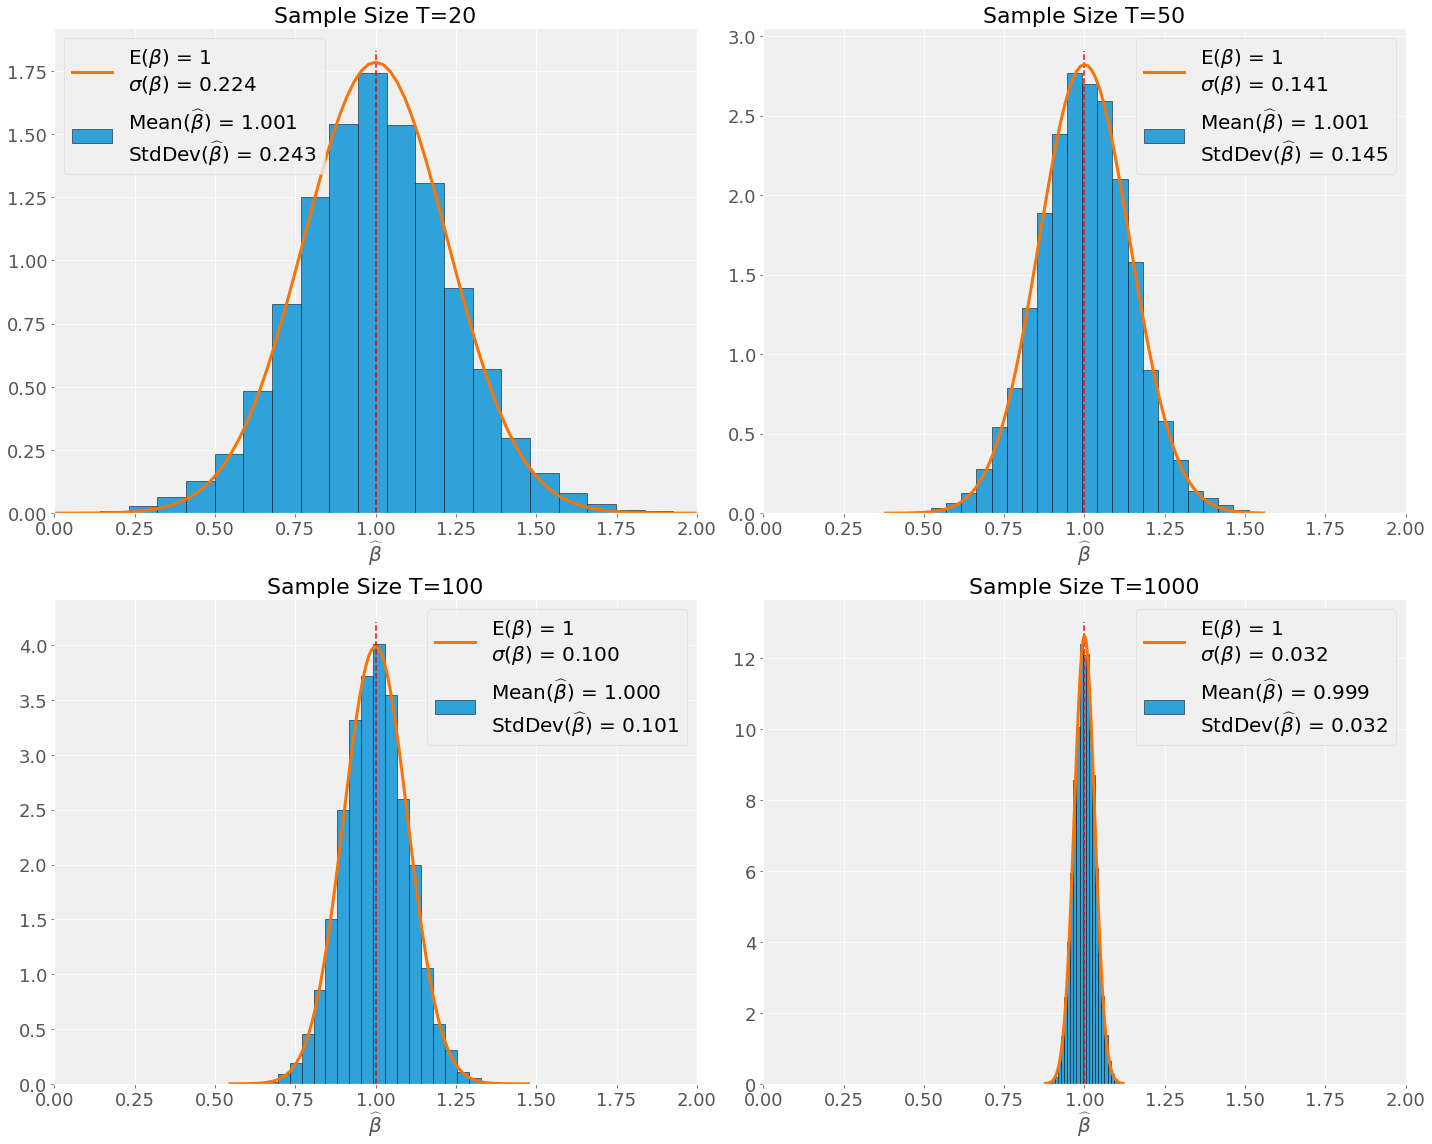

In [16]:
### Set up figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,16))
T_list = [20, 50, 100, 1000]
sims_N = 10000
dist_type = ['normal', 'norm']
dist_params = (0, 1) # mean and variance
xlims = [0, 2]

for idx, nsample in enumerate(T_list):
    idx_r, idx_c = idx//2, np.mod(idx, 2) 
    ax = axes[idx_r, idx_c]
    _, beta_hat, mc_stats =  monte_carlo_sim(const=0, nsample_T=nsample, 
                                             burnin=0, num_sims=sims_N, 
                                             dist=dist_type[0], params=dist_params)   
    ### Append summary stats...
    if idx==0:
        df_mc_stats = mc_stats 
    else:
        df_mc_stats = df_mc_stats.merge(mc_stats, how='inner', 
                                        left_index=True, right_index=True)

    beta_label = "Mean$(\widehat\\beta)$ = {:.3f}\nStdDev$(\widehat\\beta)$ = {:.3f}"\
                 .format(np.mean(beta_hat),np.std(beta_hat)) 
    ### Histogram
    ax.hist(beta_hat, bins=25, density=True, edgecolor = "black", label=beta_label) 
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_xlabel('$\widehat\\beta$', fontsize=20)
    ax.set_title('Sample Size T=%d' % nsample, fontsize=22)
    
    
    ### Asymptotic Distribution: sqrt(T)(beta_hat - beta_true) ~ N(0, Omega)
    ### where Omega = Var(x)^-1 * E[eps^2*x^2] * Var(x)^-1.
    beta_supp = np.linspace(beta_hat.min(), beta_hat.max(), 100)
    norm_mean, norm_var = dist_params    
    asymt_mean = 1
    asympt_sigma = (norm_var**-1)*(norm_var**2)*(norm_var**-1)*(nsample**-0.5)
    asympt_params = (asymt_mean, asympt_sigma) 
    ymin, ymax = ax.get_ylim()
    
    beta_label = "E$(\\beta)$ = {:.0f}\n$\sigma(\\beta)$ = {:.3f}"\
                 .format(asymt_mean, asympt_sigma)
    ax.plot((asymt_mean, asymt_mean), (ymin, ymax), 'r--')
    ax.plot(beta_supp, getattr(scipy.stats, dist_type[1]).pdf(beta_supp, *asympt_params), 
           linewidth=3, color='xkcd:orange', label=beta_label)
    ax.legend(fontsize=20)   

fig.tight_layout()

We also display a table with summary statistics for each of our Monte Carlo simulations (for $T=20,50,100,1000$):

In [17]:
### Monte Carlo summary statistics table:
df_mc_stats.T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
"T=20, params='(0, 1)'",10000,1.001,0.243,-0.126,0.411,0.610,0.700,0.841,0.996,1.159,1.309,1.399,1.594,2.105
"T=50, params='(0, 1)'",10000,1.001,0.145,0.381,0.661,0.759,0.818,0.905,1.001,1.098,1.181,1.239,1.348,1.558
"T=100, params='(0, 1)'",10000,1.000,0.101,0.547,0.761,0.835,0.873,0.931,1.000,1.066,1.129,1.168,1.241,1.476
"T=1000, params='(0, 1)'",10000,0.999,0.032,0.878,0.927,0.947,0.958,0.978,0.999,1.021,1.040,1.052,1.073,1.120


It can be shown that the solutions to both the **classical** and **asymptotic** OLS models are satisfied. 

Under the **classical** OLS model, we know that  $\widehat{\beta}|X \sim N(\beta,\sigma^2(X^{'}X)^{-1})$

while under  **asymptotic** OLS model, we know that  $\sqrt{T}(\widehat{\beta}- \beta)  \stackrel{d}{\rightarrow} N(0 , \Omega)$

where: 
$$
\Sigma_{xx} = E(x_i'x_i) = Var(x) = 1 \\
S = E[(x_i \epsilon_i)'(x_i \epsilon_i)] = E[\epsilon ^2 x^2] = 1 \\
\Omega = \Sigma_{xx}^{-1}S\Sigma_{xx}^{-1} = 1
$$

We can rewrite the **asymptotic** OLS model's distribution as 
$$
\widehat{\beta} \overset{Asy}{\sim} N(\beta, \frac{1}{T})
$$
which is displayed in gold for each of the subplots with $T=20,50,100,1000$.

## Exercise 4:

Now, repeat **Exercise 3** assuming that 
$$
1 + x, 1 + \epsilon \sim i.i.d. \chi^2_{1}
$$ 

Why do we add the constant 1 to $x$ and $\epsilon$? 

Since we are working with a Chi-squared distribution with $k=1$ degrees of freedom, then the mean of a random variable with such distribution is 1. Thus, by adding the constant 1 to both random variables, we can obtain a zero mean by adjusting the 1. This enables us to compare this problem to that of **Exercise 3**

Generally, for a random variable $\epsilon$, the $\chi^2_{1}$ probability density function looks like this:

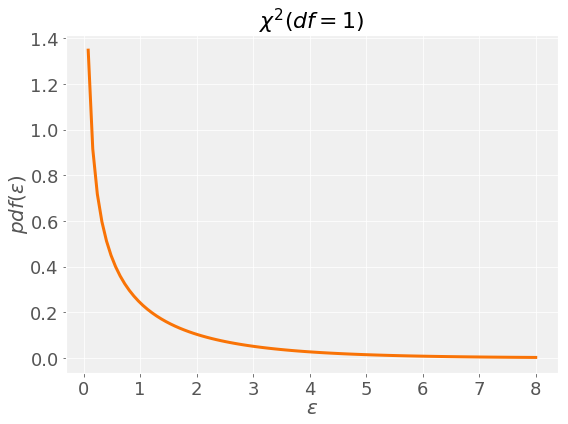

In [18]:
### chi2(df=1) pdf
df = 1 # degrees of freedom
beta_supp = np.linspace(0, 8, 100)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(beta_supp, getattr(scipy.stats, 'chi2').pdf(beta_supp, df), 
        linewidth=3, color='xkcd:orange')
ax.set_xlabel('$\epsilon$', fontsize=20)
ax.set_ylabel('$pdf(\epsilon)$', fontsize=20)
ax.set_title('$\chi^{2}(df=%d)$' % df, fontsize=22)

fig.tight_layout()

Let's run Monte Carlo simulations

In [19]:
### Test our function 'monte_carlo_sim':
###  Application: 1 + x, 1 + eps ~i.i.d. chi2(df=1) for T=100 and simulations=5
_, beta_hat, mc_stats  =  monte_carlo_sim(const=1, nsample_T=100, 
                                          burnin=0, num_sims=5, 
                                          dist='chisquare', params=1)
### Summary Stats
print(mc_stats)

      T=100, param='1'
count                5
mean             1.055
std              0.151
min              0.854
1%               0.858
5%               0.874
10%              0.894
25%              0.954
50%              1.070
75%              1.194
90%              1.198
95%              1.200
99%              1.201
max              1.202


Since $y$ is the sum of two *i.i.d.* $\chi^2_{1}$ random variables (plus a constant), then we know that
$$
y \sim i.i.d. \chi^2_{2} - 2
$$

where $\chi^2_{2}$ denotes a Chi-squared distribution with $k=2$ degrees of freedom. The mean and variance of $y$ are: 
$$
E[y]=k-2 = 0
$$
$$
Var[y]=2k=4
$$

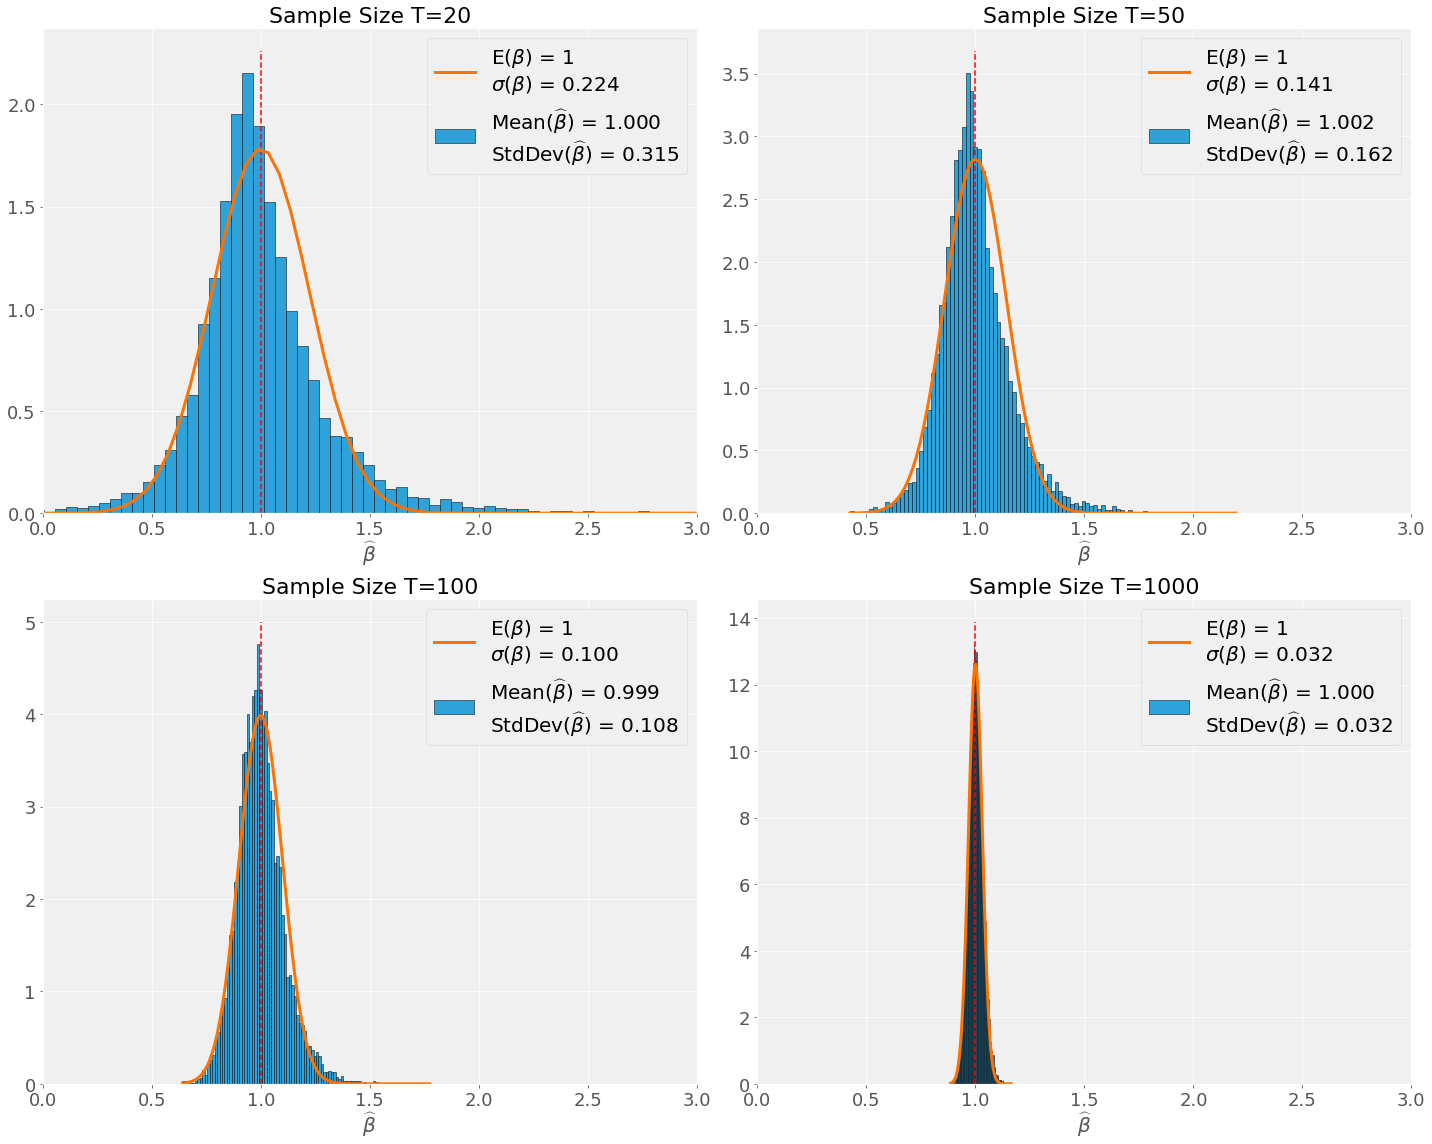

In [20]:
### Set up figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,16))
T_list = [20, 50, 100, 1000]
sims_N = 10000
dist_type = ['chisquare', 'norm']
dist_params = 1 # degrees of freedom
xlims = [0, 3]

for idx, nsample in enumerate(T_list):
    idx_r, idx_c = idx//2, np.mod(idx, 2) 
    ax = axes[idx_r, idx_c]
    _, beta_hat, mc_stats =  monte_carlo_sim(const=0, nsample_T=nsample, 
                                             burnin=0, num_sims=sims_N, 
                                             dist=dist_type[0], params=dist_params)
    
    ### Append summary stats...
    if idx==0:
        df_mc_stats = mc_stats 
    else:
        df_mc_stats = df_mc_stats.merge(mc_stats, how='inner', 
                                        left_index=True, right_index=True)
    
    beta_label = "Mean$(\widehat\\beta)$ = {:.3f}\nStdDev$(\widehat\\beta)$ = {:.3f}"\
                 .format(np.mean(beta_hat),np.std(beta_hat))        
    ### Histogram
    ax.hist(beta_hat, bins=100, density=True, edgecolor = "black", label=beta_label)   
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_xlabel('$\widehat\\beta$', fontsize=20)
    ax.set_title('Sample Size T=%d' % nsample, fontsize=22)
    
    
    
    ### Asymptotic Distribution: sqrt(T)(beta_hat - beta_true) ~ N(0,Omega)
    ### where Omega = Var(x)^-1 * E[eps^2*x^2] * Var(x)^-1.
    beta_supp = np.linspace(beta_hat.min(), beta_hat.max(), 100)
    chi2_mean, chi2_var = chi2.stats(dist_params, moments='mv') 
    asymt_mean = 1
    asympt_sigma = (chi2_var**-1)*(chi2_var**2)*(chi2_var**-1)*(nsample**-0.5)
    asympt_params = (asymt_mean, asympt_sigma) 
    ymin, ymax = ax.get_ylim()
    
    beta_label = "E$(\\beta)$ = {:.0f}\n$\sigma(\\beta)$ = {:.3f}"\
                 .format(asymt_mean, asympt_sigma)
    ax.plot((asymt_mean, asymt_mean), (ymin, ymax), 'r--')
    ax.plot(beta_supp, getattr(scipy.stats, dist_type[1]).pdf(beta_supp, *asympt_params), 
           linewidth=3, color='xkcd:orange', label=beta_label)
    ax.legend(fontsize=20) 

fig.tight_layout()

We also display a table with summary statistics for each of our Monte Carlo simulations (for $T=20,50,100,1000$):

In [21]:
### Monte Carlo summary statistics table:
df_mc_stats.T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
"T=20, param='1'",10000,1.000,0.315,-0.853,0.294,0.581,0.694,0.837,0.964,1.130,1.357,1.520,2.028,4.197
"T=50, param='1'",10000,1.002,0.162,0.424,0.658,0.775,0.825,0.903,0.984,1.081,1.198,1.289,1.510,2.195
"T=100, param='1'",10000,0.999,0.108,0.641,0.773,0.840,0.875,0.929,0.990,1.057,1.134,1.192,1.315,1.775
"T=1000, param='1'",10000,1.000,0.032,0.886,0.930,0.949,0.960,0.978,0.999,1.021,1.043,1.055,1.082,1.164


Since $\epsilon$ is no longer Gaussian, the **classical** OLS model is no longer appropriate. However, because of the *i.i.d.* assumption, we can use the **asymptotic** OLS model:
$$
\sqrt{T}(\widehat{\beta}- \beta)  \stackrel{d}{\rightarrow} N(0 , \Omega)
$$
where: 
$$
\Sigma_{xx} = E(x_i'x_i) = Var(x) = 2 \\
S = E[(x_i \epsilon_i)'(x_i \epsilon_i)] = E[\epsilon ^2 x^2] = 4 \\
\Omega = \Sigma_{xx}^{-1}S\Sigma_{xx}^{-1} = \frac{1}{4}{4} = 1
$$

We can rewrite the **asymptotic** OLS model's distribution as 
$$
\widehat{\beta} \overset{Asy}{\sim} N(\beta, \frac{1}{T})
$$
which is displayed in gold for each of the subplots with $T=20,50,100,1000$.

As $T \rightarrow \infty$, the distribution of $\widehat{\beta}$ becomes centered at $\beta=1$ and behaves more and more like a Gaussian distribution. 

## Exercise 5: Student *t*-distribution

Now, let's assume that 
$$
x, \epsilon \sim i.i.d. t_{(df=3)}
$$ 

where $t_{(df=3)}$ is a student *t*-distribution with degrees of freedom = 3.

Since $df>1$ then we know the mean of $x$ and $\epsilon$ is 0, else it would be undefined. 

Also, since $df>2$, the variance is $\frac{df}{(df -2)}$ for both random variables, else it would be $\infty$. 

For a random variable $\epsilon$, the $t_{(df=3)}$ probability density function looks like this:

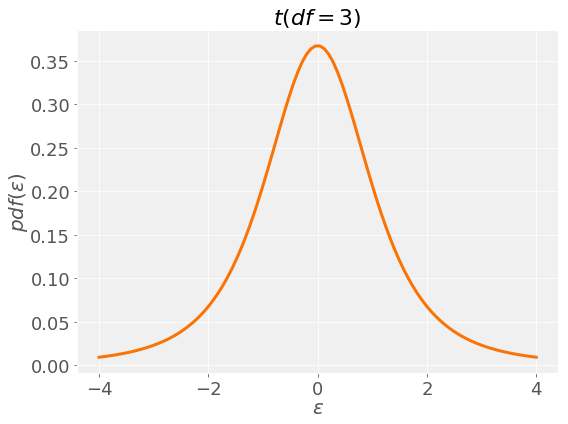

In [22]:
### t(df=3) pdf
df = 3 # degrees of freedom
beta_supp = np.linspace(-4, 4, 100)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(beta_supp, getattr(scipy.stats, 't').pdf(beta_supp, df), 
        linewidth=3, color='xkcd:orange')
ax.set_xlabel('$\epsilon$', fontsize=20)
ax.set_ylabel('$pdf(\epsilon)$', fontsize=20)
ax.set_title('$t(df=%d)$' % df, fontsize=22)

fig.tight_layout()

In [23]:
### Test our function 'monte_carlo_sim':
##  Application: x, eps ~ i.i.d. t-student(df=3) for T=100 and simulations=5
df = 3
_, beta_hat, mc_stats =  monte_carlo_sim(const=1, nsample_T=100, 
                                         burnin=0, num_sims=5, 
                                         dist='standard_t', params=df)

### Summary Stats
print(mc_stats)

      T=100, param='3'
count                5
mean             0.966
std              0.103
min              0.895
1%               0.895
5%               0.896
10%              0.897
25%              0.901
50%              0.910
75%              0.991
90%              1.078
95%              1.107
99%              1.130
max              1.136


Since $y$ is the sum of two *i.i.d.* $t_{(df=3)}$ random variables, then the distribution of $y$ will **NOT BE** a Student *t*-distribution. It will be a complicated object that will NOT BE GAUSSIAN:

**See** [this](https://arxiv.org/pdf/0906.3037.pdf)!

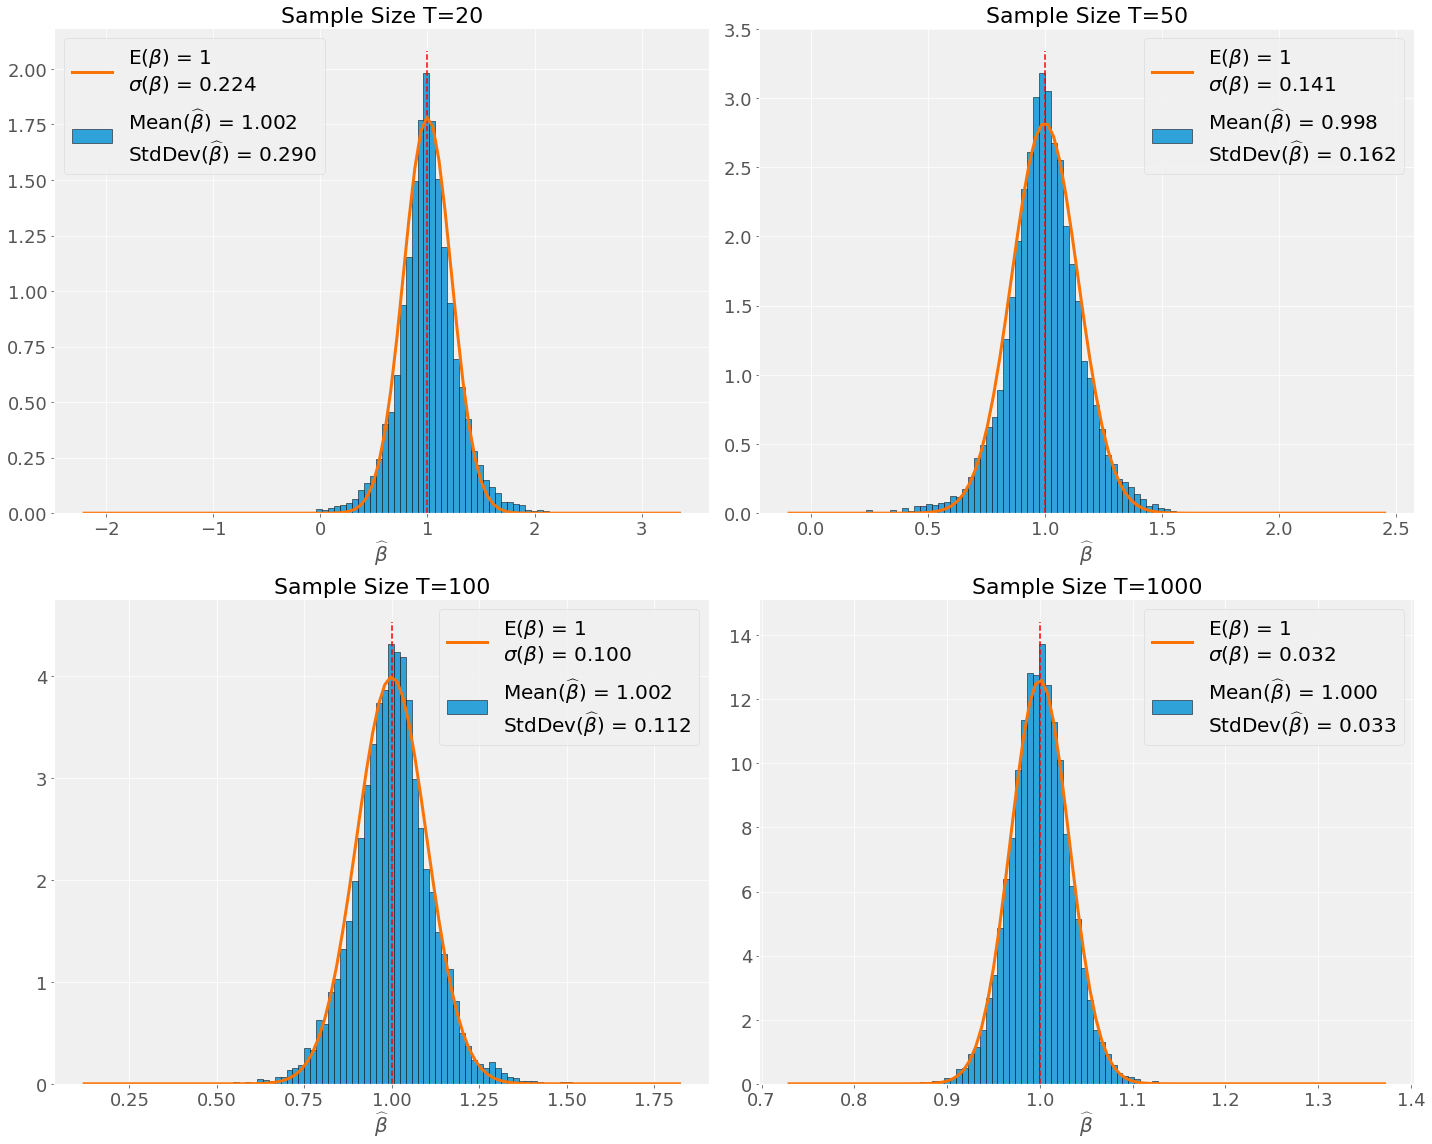

In [24]:
### Set up figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,16))
T_list = [20, 50, 100, 1000]
sims_N = 10000
dist_type = ['standard_t', 'norm']
dist_params = 3 # degrees of freedom
#xlims = [-0.5, 3]

for idx, nsample in enumerate(T_list):
    idx_r, idx_c = idx//2, np.mod(idx, 2) 
    ax = axes[idx_r, idx_c]
    _, beta_hat, mc_stats =  monte_carlo_sim(const=0, nsample_T=nsample, 
                                             burnin=0, num_sims=sims_N, 
                                             dist=dist_type[0], params=dist_params)
    
    ### Append summary stats...
    if idx==0:
        df_mc_stats = mc_stats 
    else:
        df_mc_stats = df_mc_stats.merge(mc_stats, how='inner', 
                                        left_index=True, right_index=True)
    
    beta_label = "Mean$(\widehat\\beta)$ = {:.3f}\nStdDev$(\widehat\\beta)$ = {:.3f}"\
                 .format(np.mean(beta_hat),np.std(beta_hat))                
    ### Histogram
    ax.hist(beta_hat, bins=100, density=True, edgecolor = "black", label=beta_label) 
    #ax.set_xlim(xlims[0], xlims[1])
    ax.set_xlabel('$\widehat\\beta$', fontsize=20)
    ax.set_title('Sample Size T=%d' % nsample, fontsize=22)
    
    
    ### Asymptotic Distribution: sqrt(T)(beta_hat - beta_true) ~ N(0,Omega)
    ### where Omega = Var(x)^-1 * E[eps^2*x^2] * Var(x)^-1.
    beta_supp = np.linspace(beta_hat.min(), beta_hat.max(), 100)
    t_mean, t_var = t.stats(dist_params, moments='mv')
    
    asymt_mean = 1
    asympt_sigma = (t_var**-1)*(t_var**2)*(t_var**-1)*(nsample**-0.5)
    asympt_params = (asymt_mean, asympt_sigma) 
    ymin, ymax = ax.get_ylim()
    
    beta_label = "E$(\\beta)$ = {:.0f}\n$\sigma(\\beta)$ = {:.3f}"\
                 .format(asymt_mean, asympt_sigma)    
    ax.plot((asymt_mean, asymt_mean), (ymin, ymax), 'r--')
    ax.plot(beta_supp, getattr(scipy.stats, dist_type[1]).pdf(beta_supp, *asympt_params), 
           linewidth=3, color='xkcd:orange', label=beta_label)
    ax.legend(fontsize=20)

fig.tight_layout()

We also display a table with summary statistics for each of our Monte Carlo simulations (for $T=20,50,100,1000$):

In [25]:
### Monte Carlo summary statistics table:
df_mc_stats.T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
"T=20, param='3'",10000,1.002,0.290,-2.207,0.248,0.567,0.685,0.851,0.997,1.149,1.325,1.450,1.790,3.354
"T=50, param='3'",10000,0.998,0.162,-0.092,0.558,0.741,0.814,0.908,0.997,1.089,1.189,1.256,1.405,2.451
"T=100, param='3'",10000,1.002,0.112,0.120,0.728,0.823,0.868,0.936,1.003,1.066,1.137,1.178,1.295,1.823
"T=1000, param='3'",10000,1.000,0.033,0.730,0.922,0.947,0.960,0.979,1.000,1.020,1.040,1.052,1.079,1.372


Once again, since $\epsilon$ is no longer Gaussian, the **classical** OLS model is no longer appropriate. However, because of the *i.i.d.* assumption, we can use the **asymptotic** OLS model:
$$
\sqrt{T}(\widehat{\beta}- \beta)  \stackrel{d}{\rightarrow} N(0 , \Omega)
$$
where: 
$$
\Sigma_{xx} = E(x_i'x_i) = Var(x) = \frac{3}{(3-2)}= 3\\
S = E[(x_i \epsilon_i)'(x_i \epsilon_i)] = E[\epsilon ^2 x^2] = 9 \\
\Omega = \Sigma_{xx}^{-1}S\Sigma_{xx}^{-1} = \frac{1}{9}{9} = 1
$$

We can rewrite the **asymptotic** OLS model's distribution as 
$$
\widehat{\beta} \overset{Asy}{\sim} N(\beta, \frac{1}{T})
$$
which is displayed in gold for each of the subplots with $T=20,50,100,1000$.

As $T \rightarrow \infty$, the distribution of $\widehat{\beta}$ becomes centered at $\beta=1$ and behaves more and more like a Gaussian distribution. 


## Exercise 6: Fixed T, but different Student *t*-Distributions

Let's see what happens when we fix $T$, but consider various Student t-Distributions, each *decreasing* in the degrees of freedom. 

Specifically, let's run Monte Carlo simulations with $T=100$ **fixed**, but will consider Student *t*-Distributions for the random variables $x$ and $\epsilon$ with $df=10,3,2,1$. 

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


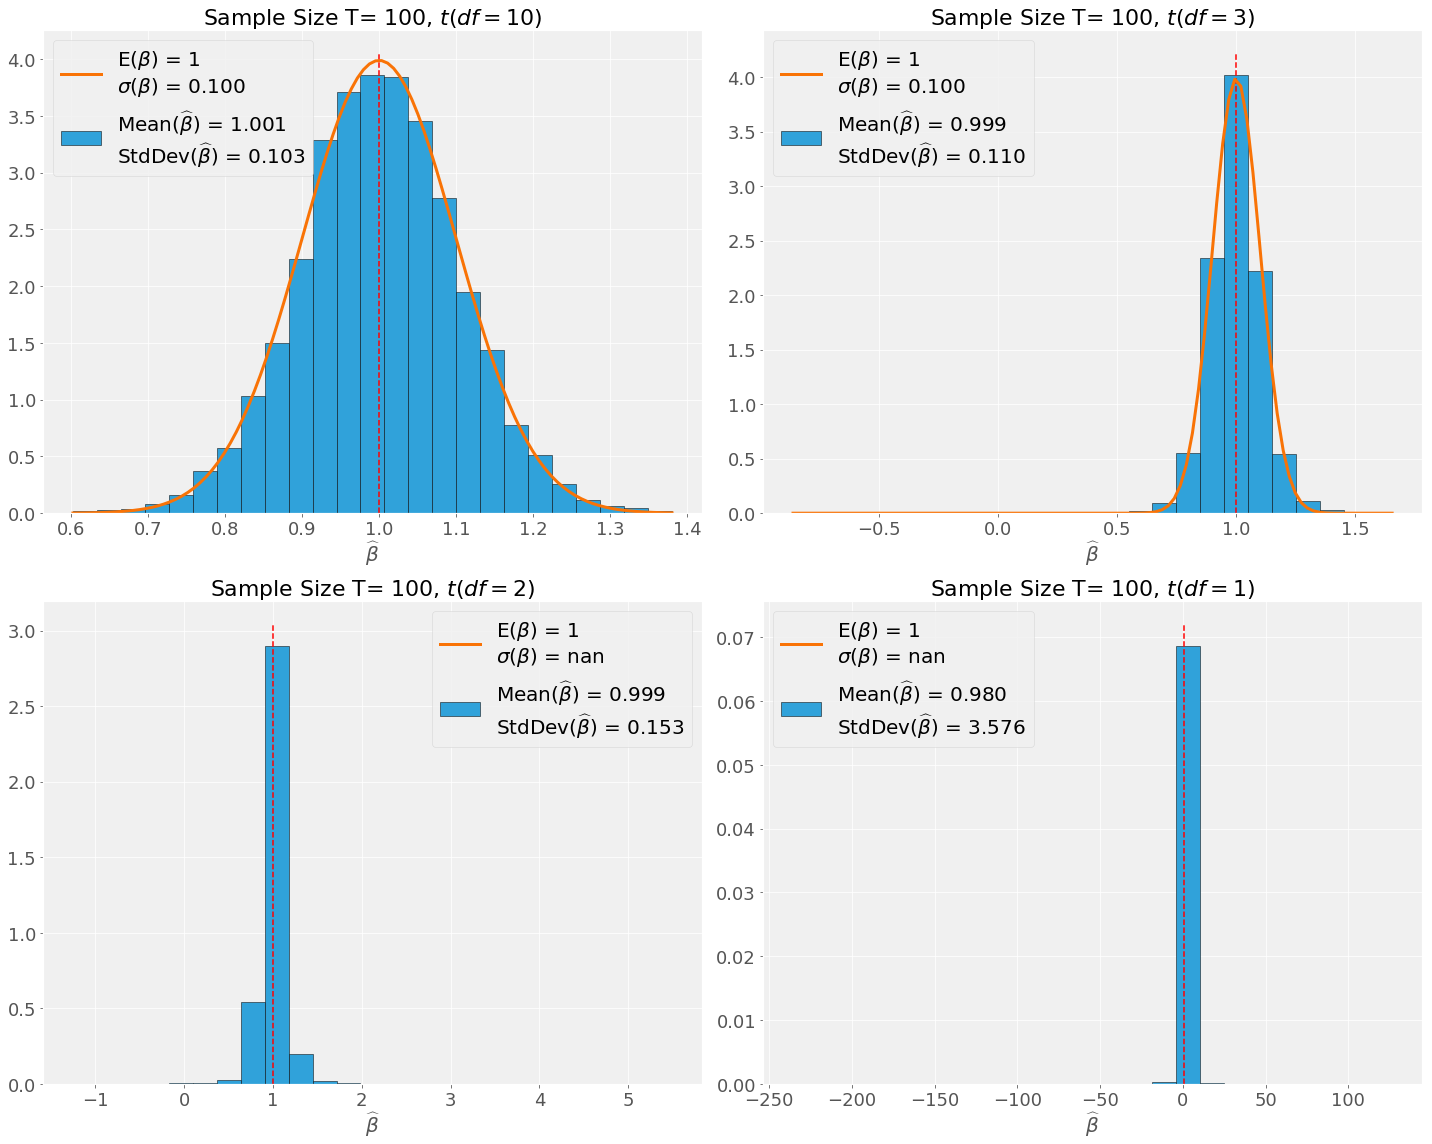

In [26]:
### Set up figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,16))
nsample = 100
sims_N = 10000
dist_type = ['standard_t', 'norm']
dist_params_list = [10, 3, 2, 1] # degrees of freedom

for idx, df in enumerate(dist_params_list):
    idx_r, idx_c = idx//2, np.mod(idx, 2) 
    ax = axes[idx_r, idx_c]
    _, beta_hat, mc_stats =  monte_carlo_sim(const=0, nsample_T=nsample, 
                                             burnin=0, num_sims=sims_N, 
                                             dist=dist_type[0],params=df)
    
    ### Append summary stats...
    if idx==0:
        df_mc_stats = mc_stats 
    else:
        df_mc_stats = df_mc_stats.merge(mc_stats, how='inner', 
                                        left_index=True, right_index=True)
    
    beta_label = "Mean$(\widehat\\beta)$ = {:.3f}\nStdDev$(\widehat\\beta)$ = {:.3f}"\
                 .format(np.mean(beta_hat),np.std(beta_hat))                
    ### Histogram
    ax.hist(beta_hat, bins=25, density=True, edgecolor = "black", label=beta_label) 
    ax.set_xlabel('$\widehat\\beta$', fontsize=20)
    ax.set_title('Sample Size T= {:.0f}, $t(df={:.0f})$'.format(nsample, df), fontsize=22)
      
    ### Asymptotic Distribution: sqrt(T)(beta_hat - beta_true) ~ N(0,Omega)
    ### where Omega = Var(x)^-1 * E[eps^2*x^2] * Var(x)^-1.
    beta_supp = np.linspace(beta_hat.min(), beta_hat.max(), 100)
    t_mean, t_var = t.stats(df, moments='mv')  
    asymt_mean = 1
    asympt_sigma = (t_var**-1)*(t_var**2)*(t_var**-1)*(nsample**-0.5)
    asympt_params = (asymt_mean, asympt_sigma) 
    ymin, ymax = ax.get_ylim()
    
    beta_label = "E$(\\beta)$ = {:.0f}\n$\sigma(\\beta)$ = {:.3f}"\
                 .format(asymt_mean, asympt_sigma)    
    ax.plot((asymt_mean, asymt_mean), (ymin, ymax), 'r--')
    ax.plot(beta_supp, getattr(scipy.stats, dist_type[1]).pdf(beta_supp, *asympt_params), 
           linewidth=3, color='xkcd:orange', label=beta_label)
    ax.legend(fontsize=20)
    
fig.tight_layout()    

Monte Carlos statistics...

In [27]:
### Monte Carlo summary statistics table:
df_mc_stats.T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
"T=100, param='10'",10000,1.001,0.103,0.603,0.758,0.831,0.872,0.933,1.000,1.068,1.131,1.168,1.244,1.380
"T=100, param='3'",10000,0.999,0.110,-0.859,0.729,0.831,0.870,0.934,0.999,1.063,1.126,1.171,1.279,1.654
"T=100, param='2'",10000,0.999,0.153,-1.252,0.620,0.810,0.867,0.942,0.999,1.055,1.131,1.191,1.380,5.493
"T=100, param='1'",10000,0.980,3.576,-235.525,-0.541,0.726,0.875,0.972,1.000,1.025,1.114,1.249,2.225,126.485


As the degrees of freedom *decrease* towards 1, we can see the asymptotic distribution of $\widehat\beta$ looks more and more degenerate. For a **fixed** sample size $T$ and $t$-distributed *i.i.d.* errors with degrees of freedom = 1, it is clear the **classical** OLS model is clearly in valid! 

Let's now **fix** $T$ at 1000: 

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


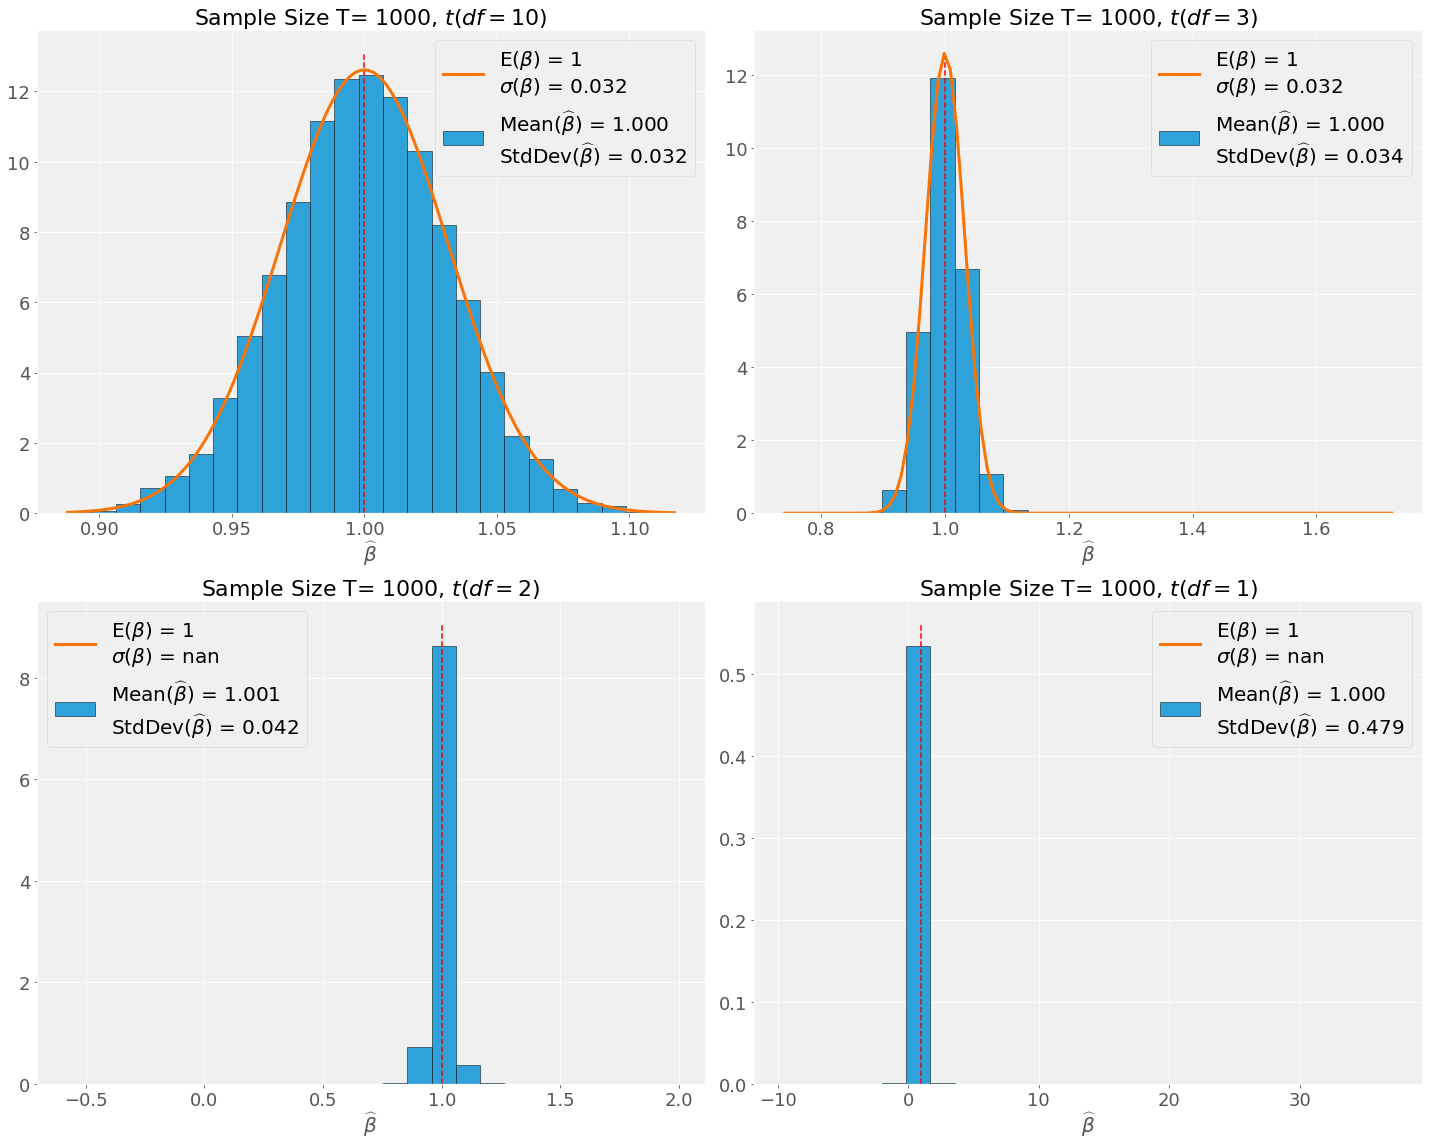

In [28]:
### Set up figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,16))
nsample = 1000
sims_N = 10000
dist_type = ['standard_t', 'norm']
dist_params_list = [10, 3, 2, 1] # degrees of freedom

for idx, df in enumerate(dist_params_list):
    idx_r, idx_c = idx//2, np.mod(idx, 2) 
    ax = axes[idx_r, idx_c]
    _, beta_hat, mc_stats =  monte_carlo_sim(const=0, nsample_T=nsample, 
                                             burnin=0, num_sims=sims_N, 
                                             dist=dist_type[0],params=df)
    
    ### Append summary stats...
    if idx==0:
        df_mc_stats = mc_stats 
    else:
        df_mc_stats = df_mc_stats.merge(mc_stats, how='inner', 
                                        left_index=True, right_index=True)

        
    
    beta_label = "Mean$(\widehat\\beta)$ = {:.3f}\nStdDev$(\widehat\\beta)$ = {:.3f}"\
                 .format(np.mean(beta_hat),np.std(beta_hat))                
    ### Histogram
    ax.hist(beta_hat, bins=25, density=True, edgecolor = "black", label=beta_label) 
    ax.set_xlabel('$\widehat\\beta$', fontsize=20)
    ax.set_title('Sample Size T= {:.0f}, $t(df={:.0f})$'.format(nsample, df), fontsize=22)
    
    
    ### Asymptotic Distribution: sqrt(T)(beta_hat - beta_true) ~ N(0,Omega)
    ### where Omega = Var(x)^-1 * E[eps^2*x^2] * Var(x)^-1.
    beta_supp = np.linspace(beta_hat.min(), beta_hat.max(), 100)
    t_mean, t_var = t.stats(df, moments='mv')  
    asymt_mean = 1
    asympt_sigma = (t_var**-1)*(t_var**2)*(t_var**-1)*(nsample**-0.5)
    asympt_params = (asymt_mean, asympt_sigma) 
    ymin, ymax = ax.get_ylim()
    
    beta_label = "E$(\\beta)$ = {:.0f}\n$\sigma(\\beta)$ = {:.3f}"\
                 .format(asymt_mean, asympt_sigma)    
    ax.plot((asymt_mean, asymt_mean), (ymin, ymax), 'r--')
    ax.plot(beta_supp, getattr(scipy.stats, dist_type[1]).pdf(beta_supp, *asympt_params), 
           linewidth=3, color='xkcd:orange', label=beta_label)
    ax.legend(fontsize=20)

fig.tight_layout()

Monte Carlo statistics...

In [29]:
### Monte Carlo summary statistics table:
df_mc_stats.T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
"T=1000, param='10'",10000,1.000,0.032,0.888,0.925,0.948,0.959,0.979,1.000,1.021,1.041,1.051,1.073,1.117
"T=1000, param='3'",10000,1.000,0.034,0.741,0.921,0.947,0.959,0.979,1.001,1.021,1.041,1.054,1.077,1.722
"T=1000, param='2'",10000,1.001,0.042,-0.577,0.910,0.948,0.963,0.983,1.000,1.018,1.038,1.054,1.100,1.980
"T=1000, param='1'",10000,1.000,0.479,-9.454,0.793,0.958,0.984,0.997,1.000,1.003,1.017,1.039,1.210,37.048


## Exercise 7: *Beta*(1/2,1/2)

Now, let's assume that 
$$
x, \epsilon \sim i.i.d. Beta(\frac{1}{2},\frac{1}{2})
$$ 

where $Beta(\frac{1}{2},\frac{1}{2})$ is a *Beta* distribution with shape parameters $\alpha=\frac{1}{2}$ and $\gamma=\frac{1}{2}$ 

A random variable $\epsilon$ with such distribution will have mean and variance given by:
$$
E[\epsilon]= \frac{\alpha}{(\alpha+\gamma)} = \frac{1}{2}
$$
$$
Var[\epsilon]= \frac{\alpha\gamma}{(\alpha+\gamma)^{2}(\alpha + \gamma + 1)} = \frac{1}{12}
$$

For a random variable $\epsilon$, the $Beta(\frac{1}{2},\frac{1}{2})$ probability density function looks like this:

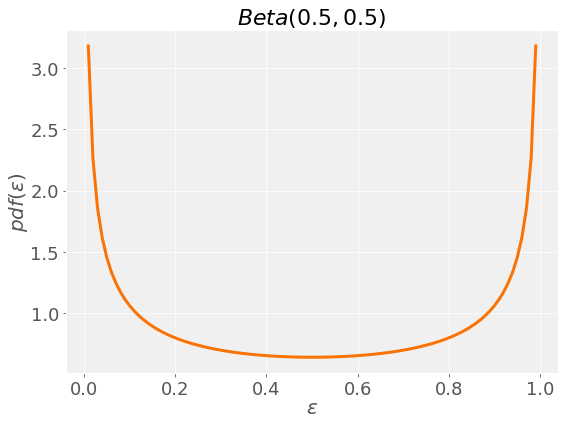

In [30]:
### Beta(0.5, 0.5) pdf
dist_params = (0.5, 0.5) # shape parameters
beta_supp = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(beta_supp, getattr(scipy.stats, 'beta').pdf(beta_supp, *dist_params), 
        linewidth=3, color='xkcd:orange')
ax.set_xlabel('$\epsilon$', fontsize=20)
ax.set_ylabel('$pdf(\epsilon)$', fontsize=20)
ax.set_title('$Beta({:.1f},{:.1f})$'.format(dist_params[0], dist_params[1]), 
             fontsize=22)

fig.tight_layout()

In [31]:
### Test our function 'monte_carlo_sim':
##  Application: x, eps ~ i.i.d. Beta(0.5, 0.5) for T=100 and simulations=5
_, beta_hat, mc_stats =  monte_carlo_sim(const=1, nsample_T=100, 
                                         burnin=0, num_sims=5, 
                                         dist='beta', params=(0.5, 0.5))

### Summary Stats
print(mc_stats)

      T=100, params='(0.5, 0.5)'
count                          5
mean                       1.036
std                        0.077
min                        0.936
1%                         0.938
5%                         0.944
10%                        0.952
25%                        0.977
50%                        1.059
75%                        1.091
90%                        1.107
95%                        1.112
99%                        1.117
max                        1.118


Let's run some Monte Carlo simulations:

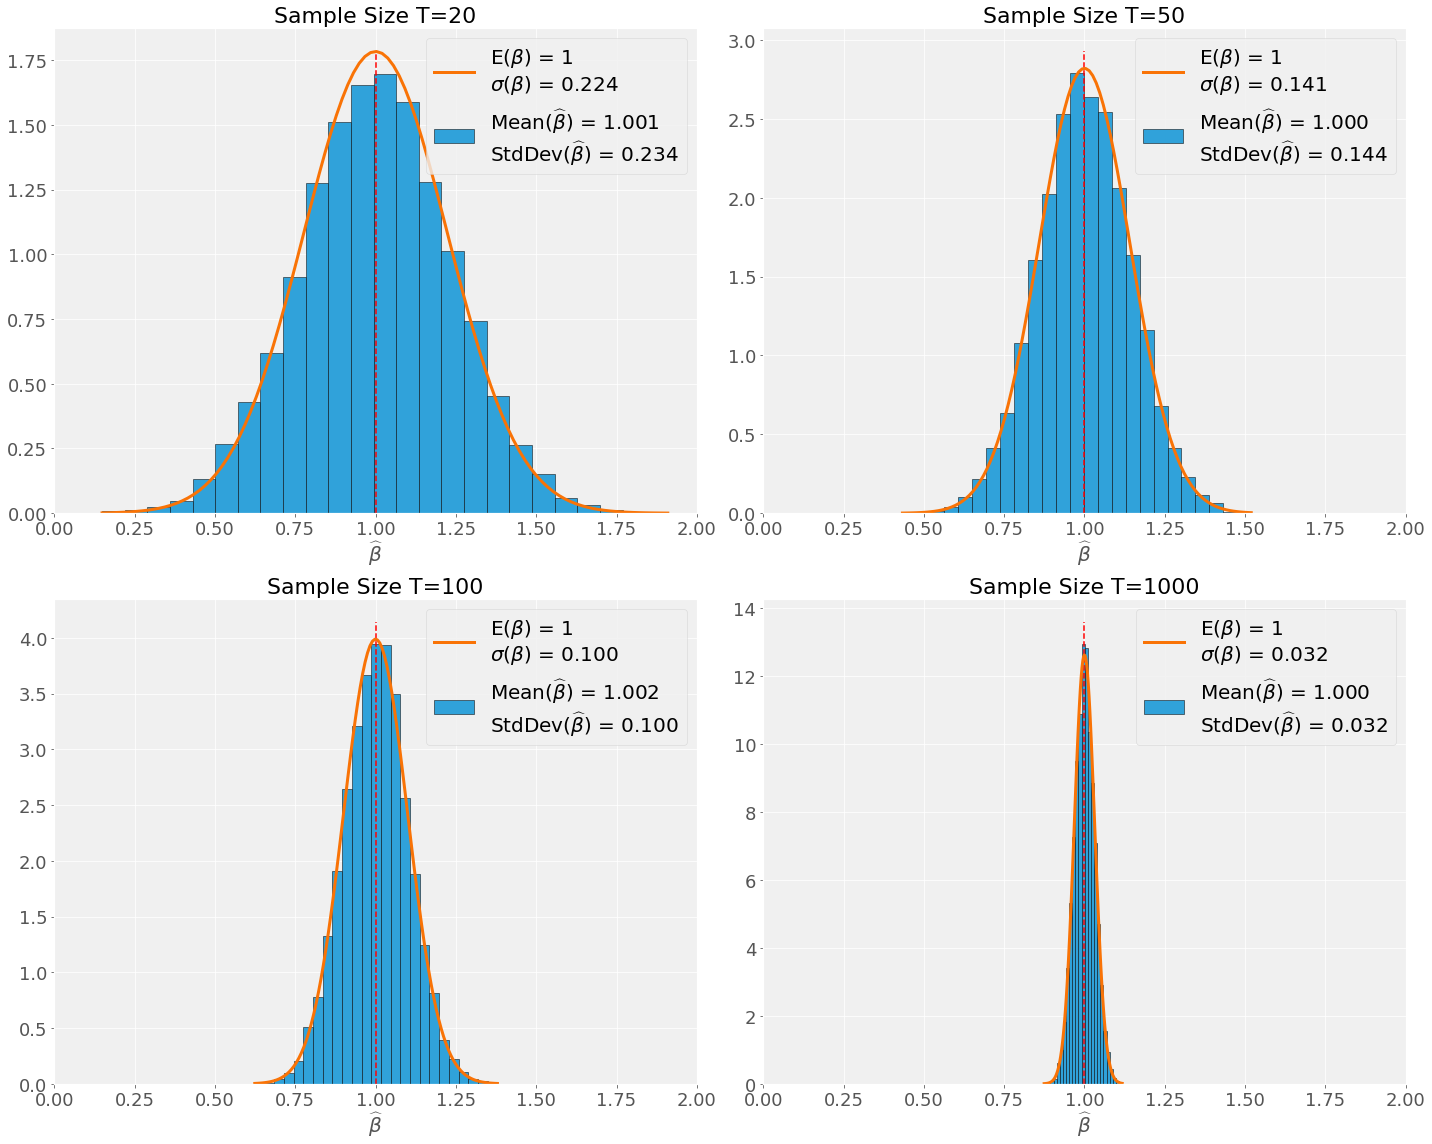

In [32]:
### Set up figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,16))
T_list = [20, 50, 100, 1000]
sims_N = 10000
dist_type = ['beta', 'norm']
dist_params = (0.5, 0.5) # shape parameters
xlims = [0, 2]

for idx, nsample in enumerate(T_list):
    idx_r, idx_c = idx//2, np.mod(idx, 2) 
    ax = axes[idx_r, idx_c]
    _, beta_hat, mc_stats =  monte_carlo_sim(const=0, nsample_T=nsample, 
                                             burnin=0, num_sims=sims_N, 
                                             dist=dist_type[0], params=dist_params)
    ### Append summary stats...
    if idx==0:
        df_mc_stats = mc_stats 
    else:
        df_mc_stats = df_mc_stats.merge(mc_stats, how='inner', 
                                        left_index=True, right_index=True)
       
    beta_label = "Mean$(\widehat\\beta)$ = {:.3f}\nStdDev$(\widehat\\beta)$ = {:.3f}"\
                 .format(np.mean(beta_hat),np.std(beta_hat))                
    ### Histogram
    ax.hist(beta_hat, bins=25, density=True, edgecolor = "black", label=beta_label) 
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_xlabel('$\widehat\\beta$', fontsize=20)
    ax.set_title('Sample Size T=%d' % nsample, fontsize=22)
     
    ### Asymptotic Distribution: sqrt(T)(beta_hat - beta_true) ~ N(0,Omega)
    ### where Omega = Var(x)^-1 * E[eps^2*x^2] * Var(x)^-1.
    beta_supp = np.linspace(beta_hat.min(), beta_hat.max(), 100)
    BETA_mean, BETA_var =  beta.stats(*dist_params, moments='mv')  
    asymt_mean = 1
    asympt_sigma = (BETA_var**-1)*(BETA_var**2)*(BETA_var**-1)*(nsample**-0.5)
    asympt_params = (asymt_mean, asympt_sigma) 
    ymin, ymax = ax.get_ylim()
    
    beta_label = "E$(\\beta)$ = {:.0f}\n$\sigma(\\beta)$ = {:.3f}"\
                 .format(asymt_mean, asympt_sigma)    
    ax.plot((asymt_mean, asymt_mean), (ymin, ymax), 'r--')
    ax.plot(beta_supp, getattr(scipy.stats, dist_type[1]).pdf(beta_supp, *asympt_params), 
           linewidth=3, color='xkcd:orange', label=beta_label)
    ax.legend(fontsize=20)
    
fig.tight_layout()

Let's check the Monte Carlo statistics:

In [33]:
### Monte Carlo summary statistics table:
df_mc_stats.T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
"T=20, params='(0.5, 0.5)'",10000,1.001,0.234,0.149,0.461,0.614,0.700,0.844,1.002,1.157,1.300,1.382,1.534,1.910
"T=50, params='(0.5, 0.5)'",10000,1.000,0.144,0.433,0.667,0.765,0.818,0.903,0.999,1.096,1.185,1.238,1.339,1.519
"T=100, params='(0.5, 0.5)'",10000,1.002,0.100,0.624,0.773,0.836,0.873,0.934,1.003,1.068,1.129,1.167,1.237,1.379
"T=1000, params='(0.5, 0.5)'",10000,1.000,0.032,0.874,0.924,0.947,0.958,0.978,0.999,1.021,1.041,1.051,1.075,1.117


Even when both $x$ and $\epsilon$ have a **VERY** non-normal distribution like a $Beta(\frac{1}{2}, \frac{1}{2})$ it appears that the **classical** OLS is ok and the  **asymptotic** OLS models is a lot better. 

## Exercise 8:

Let's use annual (log) price multiples from `quandl`.


* **Part A:** Plot the data and perform the preliminary data analysis as discussed in class.
* **Part B:** Plot the ACF and PACF. What do we learn?
* **Part C:** Compute the OLS regression for the AR($1$) and AR($2$) models:
$$
x_t = \mu + \phi_{1}x_{t-1} + \epsilon_t \\
x_t = \mu + \phi_{1}x_{t-1} + \phi_{2}x_{t-2} + \epsilon_t
$$
* **Part D:** Report the OLS coefficients, their SEs with and without robust (White) errors, as well as other standard regression output. 
* **Part E:** Compute the roots of both models.
* **Part F:** Plot the impulse response function for both the AR($1$) and AR($2$) model.
* **Part G:** Compare both AR models using the criterion discussed in lecture. Which model is preferred? Why?

Let's use the **annual (log) S&P 500 Price-Earnings ratio**. 

The raw data will be the `S&P 500 PE Ratio by Year` provided by Quandl, which is based on trailing twelve month as reported earnings. Current PE is estimated from latest reported earnings and current market price. This data was compiled by Robert Shiller for use in his book *Irrational Exuberance* for historic S&P 500 PE Ratio.

In [34]:
### =True if accessing data remotely.
access_quandl = False

if access_quandl:
    ### Import quandl and set API Options
    ### If this fails, then just load .csv file with raw data
    import sys
    import os
    import quandl
    from dotenv import load_dotenv
    quandl.ApiConfig.api_key = os.getenv('QUANDL_API_KEY')
    quandl.ApiConfig.api_version = os.getenv('QUANDL_API_VERSION')

    ### dotenv loads (or re-loads) the .env file in your home directory.
    %reload_ext dotenv
    %dotenv

    ### Download annual data from quandl:
    dfquandl = quandl.get('MULTPL/SP500_PE_RATIO_YEAR')
    dfquandl.rename(columns={'Value': 'Level'}, inplace=True)
    dfquandl.index = dfquandl.index.year
    
    ### Save file to .csv
    dfquandl.to_csv('MULTPL_SP500_PE_RATIO_YEAR.csv')
else:
    dfquandl = pd.read_csv('MULTPL_SP500_PE_RATIO_YEAR.csv', index_col=['Date'])
    
print(dfquandl.head(), '\n')
print(dfquandl.tail(), '\n')
print(dfquandl.info(), '\n')

      Level
Date       
1871 11.100
1872 12.070
1873 11.820
1874 10.130
1875 10.050 

      Level
Date       
2015 20.020
2016 22.180
2017 23.590
2018 24.970
2019 19.450 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 1871 to 2019
Data columns (total 1 columns):
Level    149 non-null float64
dtypes: float64(1)
memory usage: 2.3 KB
None 



### Part A: Let's plot the raw data and then take natural logs:

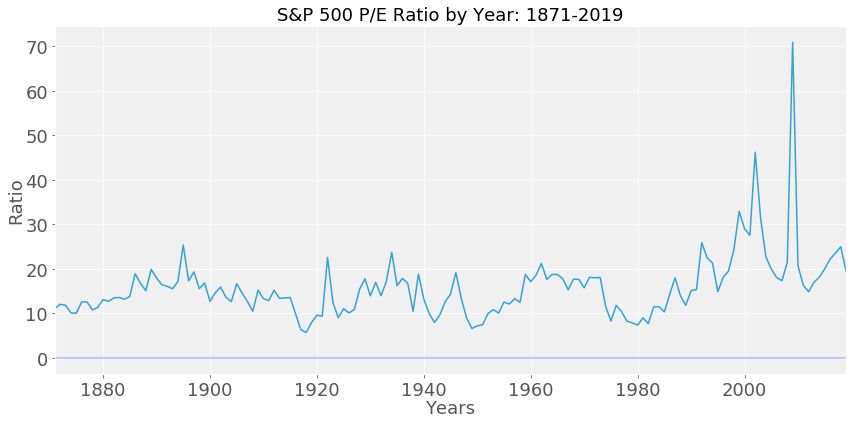

In [35]:
### Plot levels
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(dfquandl['Level'])

axes.set_xlim(dfquandl.index.min(), dfquandl.index.max())
axes.set_xlabel('Years', fontsize=18)
axes.set_ylabel('Ratio', fontsize=18)
axes.set_title('S&P 500 P/E Ratio by Year: ' + str(dfquandl.index.min()) + '-'
               + str(dfquandl.index.max()), fontsize=18)
axes.axhline(y=0, linewidth=0.4)
fig.tight_layout()

It is clear the S&P 500 P/E ratio is **non-stationary** since its volatility is clearly not constant. 

There are some sub-samples (e.g 1980 - present) that exhibit some upward trend.

Now. let's take logs and plot:

      Level   Log
Date             
1871 11.100 2.407
1872 12.070 2.491
1873 11.820 2.470
1874 10.130 2.316
1875 10.050 2.308 

      Level   Log
Date             
2015 20.020 2.997
2016 22.180 3.099
2017 23.590 3.161
2018 24.970 3.218
2019 19.450 2.968 



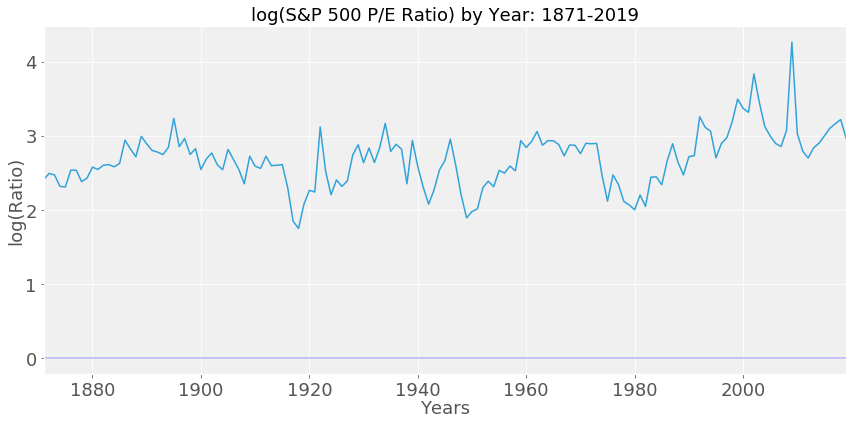

In [36]:
### Take logs
dfquandl['Log'] = dfquandl['Level'].apply(np.log)
print(dfquandl.head(), '\n')
print(dfquandl.tail(), '\n')

### Plot logs
fig, axes = plt.subplots(figsize=(12,6))
axes.plot(dfquandl['Log'])

axes.set_xlim(dfquandl.index.min(), dfquandl.index.max())
axes.set_xlabel('Years', fontsize=18)
axes.set_ylabel('log(Ratio)', fontsize=18)
axes.set_title('log(S&P 500 P/E Ratio) by Year: ' + str(dfquandl.index.min()) + '-'
               + str(dfquandl.index.max()), fontsize=18)
axes.axhline(y=0, linewidth=0.4)
fig.tight_layout()

Taking natural logs reduces some of the spikes in volatility that were present in certain sub-samples. 

The jury is out on whether the annual log of the S&P 500 P/E ratio is stationary or not...

### Part B: Plotting the **ACF/PACF**

We can use our "brute force" ACF/PACF plotting code from **Lab 2** or their `statsmodels` versions (only during the lab session...)

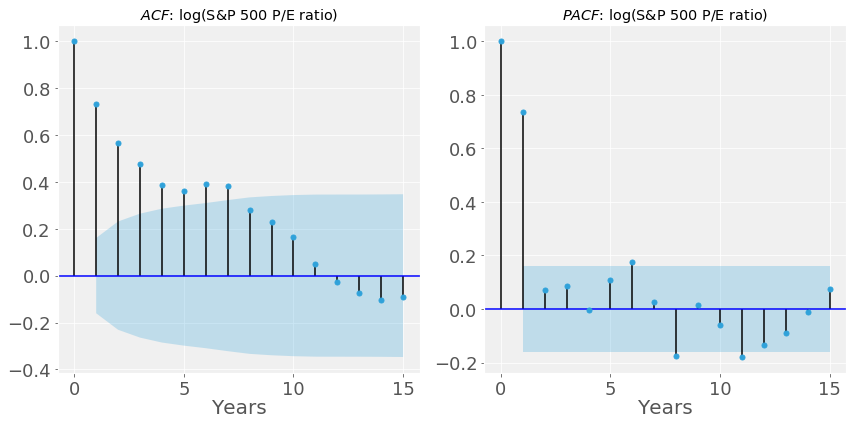

In [37]:
### Import 'statsmodels' routines for  ACF/PACF plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
nlags = 15
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plot_acf(dfquandl['Log'], ax=axes[0], lags=nlags, 
         title="${\it ACF}$: log(S&P 500 P/E ratio)")

plot_pacf(dfquandl['Log'], ax=axes[1], lags=nlags, 
         title="${\it PACF}$: log(S&P 500 P/E ratio)")

axes[0].set_xlabel('Years', fontsize=20)
axes[1].set_xlabel('Years', fontsize=20)
fig.tight_layout()

What do we learn?

### Part C-D: Compute the OLS Regressions for the two AR models

You have all coded "brute force" versions of OLS estimation techniques that provide regression estimates, non-robust and robust SEs, as well as other statistics of interest (e.g. $R^2$, adjusted  $R^2$, $AIC$, $BIC$, etc.). We continue to use "brute force" code. We will then double check it `statsmodels`.

First, I will write a function `nth_moment` which computes the **nth-sample moment** centered around some value. 

In [38]:
def nth_moment(y, counts, center, n):
    """ Calculates nth moment around 'center"""
    return np.sum((y - center)**n) / np.sum(counts)

In [39]:
def calc_ols(y, x, addcon=True):
    """Calculate OLS coefficients, SEs, and other statistics from scratch"""
    Nobs = y.shape[0]
    if addcon:
        X = np.c_[np.ones((Nobs, 1)), x] # append the [Nobs x 1] columns of ones.
    else:
        X = x    
    k = X.shape[1]    
    XX = np.dot(X.T, X) # Construct sample average of E[X'X]
    Xy = np.dot(X.T, y) # Construct sample average of E[X'Y]
    XX_inv = np.linalg.inv(XX)
    
    ### OLS estimator: algebraic solution for OLS. beta_hat = (E[X'X]^-1)*(E[X'Y])
    beta_hat = np.linalg.solve(XX, Xy) 

    ### R-squared (can use np.dot or @ for "dot product")
    y_hat = np.dot(X, beta_hat)
    resids = y - y_hat
    sse = np.dot(resids.T, resids)
    
    sst = (y - np.mean(y)).T@(y - np.mean(y))
    r_squared = 1 - (sse/sst) 

    ### Adjusted R-squared
    r_squared_adj = r_squared - (1 - r_squared)*((k - 1)/(Nobs - k))
    
    ### Variance-Covariance matrix: non-robust homoskedastic SEs
    sigma2_hat = sse / (Nobs - k)
    sigma2_mle = sse / (Nobs - 1)
    cov_matrix = np.dot(XX_inv, sigma2_hat)
    se = cov_matrix.diagonal()**0.5
    t_stat = beta_hat / se


    ### Variance-Covariance matrix: White (robust) heteroskedastic SEs:
    cov_matrix_robust = np.dot(np.dot(np.dot(np.dot(XX_inv, X.T), np.diag(resids**2)),X),XX_inv)
    cov_matrix_robust_unbiased = cov_matrix_robust 
    se_robust = cov_matrix_robust_unbiased.diagonal()**0.5
    t_stat_robust = beta_hat / se_robust
    
    ### log-likelihood (assumption of normality:
    loglikelihood = - (Nobs/2)*np.log(2*np.math.pi) - \
                      (Nobs/2)*np.log(sigma2_mle) - \
                      (1/(2*sigma2_mle))*sum(resids**2)
   
    ### Information criteria:
    hannan_quinn = ((-2*loglikelihood)/Nobs) + ((2*(k - 1)*math.log(math.log(Nobs)))/Nobs)
    aic = Nobs *(math.log(2*math.pi) + 1 + math.log((sum(resids**2)/(Nobs)))) + (((k - 1) + 1)*2)
    bic = -2*loglikelihood + math.log(Nobs)*((k - 1) + 1)
    
    ### Higher-order moments of the residuals:
    m1 = nth_moment(resids, resids.shape[0], center=0,  n=1)
    m2 = nth_moment(resids, resids.shape[0], center=m1, n=2)
    m3 = nth_moment(resids, resids.shape[0], center=m1, n=3)
    m4 = nth_moment(resids, resids.shape[0], center=m1, n=4)   
    skew = m3 / (m2**(3/2))
    kurtosis = m4 / (m2**2)
    
    ols_results = {'beta_hat': beta_hat,
                   'standard-errors': se, 
                   't-stat': t_stat, 
                   'standard-errors (robust)': se_robust, 
                   't-stat (robust)': t_stat_robust}                   

    stats = {"No. Observations": Nobs,
             "Df Residuals": Nobs - k,
             "Skewness of residuals:": skew,
             "Kurtosis of residuals:": kurtosis,
             "$R^2$":  r_squared,
             "adjusted-$R^2$": r_squared_adj,
             "Log-likelihood": loglikelihood,
             "Hannan-Quinn": hannan_quinn,
             "AIC": aic, 
             "BIC": bic}
    
    return ols_results, stats

The code below constructs both the current and lagged values for estimating our AR models.

In [40]:
### Create data for OLS regressions: AR(1) and AR(2):
dfquandl['Log_lag1'] = dfquandl['Log'].shift(1)
dfquandl['Log_lag2'] = dfquandl['Log_lag1'].shift(1)
dfquandl = dfquandl.dropna() # drop missings

y_lhs = dfquandl['Log']
x_rhs_ar1 = dfquandl['Log_lag1']
x_rhs_ar2 = dfquandl[['Log_lag1', 'Log_lag2']]

print(y_lhs.head(), '\n')
print(x_rhs_ar1.head(), '\n')
print(x_rhs_ar2.head(), '\n')   

Date
1873   2.470
1874   2.316
1875   2.308
1876   2.535
1877   2.534
Name: Log, dtype: float64 

Date
1873   2.491
1874   2.470
1875   2.316
1876   2.308
1877   2.535
Name: Log_lag1, dtype: float64 

      Log_lag1  Log_lag2
Date                    
1873     2.491     2.407
1874     2.470     2.491
1875     2.316     2.470
1876     2.308     2.316
1877     2.535     2.308 



#### AR(1) model:

In [41]:
### Compute AR(1) via OLS: parameter estimates
ar1_results, ar1_stats = calc_ols(y_lhs, x_rhs_ar1)
print(ar1_results)

ar1_est_df = pd.DataFrame(index=["$\mu$", "$\phi_{1}$"])
ar1_est_df["Estimates"] = ar1_results['beta_hat']
ar1_est_df["(non-robust) SEs"] = ar1_results['standard-errors']
ar1_est_df["(non-robust) $t$-stat"] = ar1_results['t-stat']
ar1_est_df["(robust) SEs"] = ar1_results['standard-errors (robust)']
ar1_est_df["(robust) $t$-stat"] = ar1_results['t-stat (robust)']
ar1_est_df

{'beta_hat': array([0.715, 0.734]), 'standard-errors': array([0.153, 0.056]), 't-stat': array([ 4.678, 12.999]), 'standard-errors (robust)': array([0.219, 0.083]), 't-stat (robust)': array([3.271, 8.807])}


,Estimates,(non-robust) SEs,(non-robust) $t$-stat,(robust) SEs,(robust) $t$-stat
$\mu$,0.715,0.153,4.678,0.219,3.271
$\phi_{1}$,0.734,0.056,12.999,0.083,8.807


In [42]:
### Compute AR(1) via OLS: statistics
ar1_stat_df = pd.DataFrame.from_dict(ar1_stats, orient='index', 
                                     columns=['OLS statistics/diag'])
ar1_stat_df.loc['No. Observations'] = ar1_stat_df.loc['No. Observations'].apply('{:.0f}'.format)
ar1_stat_df.loc['Df Residuals'] = ar1_stat_df.loc['Df Residuals'].apply('{:.0f}'.format)
ar1_stat_df

,OLS statistics/diag
No. Observations,147
Df Residuals,145
Skewness of residuals:,0.877
Kurtosis of residuals:,7.599
$R^2$,0.538
adjusted-$R^2$,0.535
Log-likelihood,-6.299
Hannan-Quinn,0.108
AIC,16.595
BIC,22.580


We will check our results with the `statsmodel` OLS routine. I will use the "wrapper" for the `statsmodels` OLS estimation routine from **Lab 2**.

In [43]:
### See: https://stackoverflow.com/questions/20701484/why-do-i-get-only-one-parameter-from-a-statsmodels-ols-fit
def _sm_calc_ols(y, x, addcon=True, summary=1, cov_type='nonrobust'):
    """Wrapper for statsmodels OLS regression"""
    if addcon==1:
        X = sm.add_constant(x)
    else: 
        X = x 
    ols_results = sm.OLS(y,X).fit(cov_type=cov_type)
    
    ### print out the OLS estimation results
    if summary==1:
        print(ols_results.summary())      
        
    beta_hat = ols_results.params # beta_hat
    resids = ols_results.resid  # resids   
    
    return beta_hat

Using `statsmodels`, we first report OLS coefficients, their **(non-robust) homoskedastic standard errors**, and also other standard regression output for the AR($1$) model:

In [44]:
### Compute AR(1) via 'statsmodels' OLS: non-robust SEs.
beta_hat_ar1 = _sm_calc_ols(y_lhs, x_rhs_ar1, addcon=True, summary=1)

                            OLS Regression Results                            
Dep. Variable:                    Log   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     169.0
Date:                Sat, 18 May 2019   Prob (F-statistic):           4.23e-26
Time:                        01:21:23   Log-Likelihood:                -6.2977
No. Observations:                 147   AIC:                             16.60
Df Residuals:                     145   BIC:                             22.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7155      0.153      4.678      0.0

/Users/chris.jauregui/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Now, we report OLS coefficients with **White (robust) heteroskedastic standard errors**, and other standard regression output for the AR($1$) model:

In [45]:
### Compute AR(1) via 'statsmodels' OLS: White (robust) heteroskedastic SEs:
beta_hat_ar1 = _sm_calc_ols(y_lhs, x_rhs_ar1, addcon=True, summary=1, cov_type='HC0')

                            OLS Regression Results                            
Dep. Variable:                    Log   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     77.56
Date:                Sat, 18 May 2019   Prob (F-statistic):           3.58e-15
Time:                        01:21:23   Log-Likelihood:                -6.2977
No. Observations:                 147   AIC:                             16.60
Df Residuals:                     145   BIC:                             22.58
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7155      0.219      3.271      0.0

#### AR(2) model:

Let's add another lag to our `x_rhs` matrix:

In [46]:
print(y_lhs.head(), '\n')
print(x_rhs_ar2.head(), '\n')   

Date
1873   2.470
1874   2.316
1875   2.308
1876   2.535
1877   2.534
Name: Log, dtype: float64 

      Log_lag1  Log_lag2
Date                    
1873     2.491     2.407
1874     2.470     2.491
1875     2.316     2.470
1876     2.308     2.316
1877     2.535     2.308 



In [47]:
### Compute AR(2) via OLS: parameter estimates
ar2_results, ar2_stats = calc_ols(y_lhs, x_rhs_ar2)

ar2_est_df = pd.DataFrame(index=["$\mu$", "$\phi_{1}$", "$\phi_{2}$"])
ar2_est_df["Estimates"] = ar2_results['beta_hat']
ar2_est_df["(non-robust) SEs"] = ar2_results['standard-errors']
ar2_est_df["(non-robust) $t$-stat"] = ar2_results['t-stat']
ar2_est_df["(robust) SEs"] = ar2_results['standard-errors (robust)']
ar2_est_df["(robust) $t$-stat"] = ar2_results['t-stat (robust)']
ar2_est_df

,Estimates,(non-robust) SEs,(non-robust) $t$-stat,(robust) SEs,(robust) $t$-stat
$\mu$,0.660,0.164,4.012,0.180,3.659
$\phi_{1}$,0.678,0.083,8.154,0.136,4.995
$\phi_{2}$,0.077,0.084,0.925,0.102,0.759


In [48]:
### Compute AR(2) via OLS: statistics
ar2_stat_df = pd.DataFrame.from_dict(ar2_stats, orient='index', 
                                     columns=['OLS statistics/diag'])
ar2_stat_df.loc['No. Observations'] = ar2_stat_df.loc['No. Observations'].apply('{:.0f}'.format)
ar2_stat_df.loc['Df Residuals'] = ar2_stat_df.loc['Df Residuals'].apply('{:.0f}'.format)
ar2_stat_df

,OLS statistics/diag
No. Observations,147
Df Residuals,144
Skewness of residuals:,0.913
Kurtosis of residuals:,7.638
$R^2$,0.541
adjusted-$R^2$,0.535
Log-likelihood,-5.864
Hannan-Quinn,0.124
AIC,17.724
BIC,26.698


Using `statsmodels`, we first report OLS coefficients, their **(non-robust) homoskedastic standard errors**, and other standard regression output for the AR($2$) model:

In [49]:
### Compute AR(2) via 'statsmodels' OLS: non-robust SEs.
beta_hat_ar2 = _sm_calc_ols(y_lhs, x_rhs_ar2, addcon=True, summary=1)

                            OLS Regression Results                            
Dep. Variable:                    Log   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     84.83
Date:                Sat, 18 May 2019   Prob (F-statistic):           4.53e-25
Time:                        01:21:23   Log-Likelihood:                -5.8618
No. Observations:                 147   AIC:                             17.72
Df Residuals:                     144   BIC:                             26.69
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6598      0.164      4.012      0.0

Now, we report OLS coefficients with **White (robust) heteroskedastic standard errors**, and other standard regression output for the AR($2$) model:

In [50]:
### Compute AR(2) via 'statsmodels' OLS: White (robust) heteroskedastic SEs:
beta_hat_ar2 = _sm_calc_ols(y_lhs, x_rhs_ar2, addcon=True, summary=1, cov_type='HC0')

                            OLS Regression Results                            
Dep. Variable:                    Log   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     66.06
Date:                Sat, 18 May 2019   Prob (F-statistic):           4.41e-21
Time:                        01:21:23   Log-Likelihood:                -5.8618
No. Observations:                 147   AIC:                             17.72
Df Residuals:                     144   BIC:                             26.69
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6598      0.180      3.659      0.0

### Part E: Compute the roots:

Let's write a function that computes the roots for each of our AR($1$) and AR($2$) models. 

In [51]:
def compute_root(ar_coef):
    ar_coef = np.array(ar_coef)
    ar_coef = -np.flip(ar_coef.flatten()[1:])
    ar_coef = np.concatenate((ar_coef, [1]))
    roots = np.roots(ar_coef)
    return roots

In [52]:
### Test the function:
ar1_roots = compute_root(beta_hat_ar1)
print('AR(1) process has root: {:.3f}'.format(float(ar1_roots)))

AR(1) process has root: 1.362


In [53]:
### Test the function:
ar2_roots = compute_root(beta_hat_ar2)
print('AR(2) process has roots: {:.3f} and {:.3f}'.format(ar2_roots[0], ar2_roots[1]))

AR(2) process has roots: -10.050 and 1.286


Let's check if we did this right! We can do that with a code we wrote that starts from the roots and then provides the coefficients for an ARMA($p$,$q$) process:

In [54]:
def _roots2coef(roots):
    """Given roots, get the coefficients"""
    ### SymPy: package for symbolic computation
    from sympy import symbols, expand, factor, collect, simplify, Mul
    
    N_roots = len(roots)
    L = symbols("L", commutative=False) # symbolic variable
    ## Construct lag polynomial in the canonical form
    expr = expand(1)
    for r in roots:
        expr*= -(L - r)
    expr_expand = expand(expr)
    expr_expand = expand((expr_expand.as_coefficients_dict()[1]**-1)*expr_expand).evalf(3)
    
    ## factor out the lag polynomials and get "factor list" in the canonical form
    expr_factor = factor(expr_expand)     
    for f in range(1, len(expr_factor.args)):
        if f==1:
            expr = expand(expr_factor.args[f]*-1).evalf(3)
        else:
            expr = Mul(expr, expand(expr_factor.args[f]*-1).evalf(3))
            
    coef_list = [expr_expand.coeff(L,n) for n in range(N_roots + 1)]
    ### convert to numpy floats
    coefs = np.array(coef_list).astype(float)
    ### normalize zero lag to 1
    coefs /= coefs[0]
    return coefs, expr, expr_expand

def arma_from_roots(ar_roots=[], ma_roots=[]):
    """Create an ARMA model class from roots"""    
    ar_coef, ar_expr, ar_expr_expand = _roots2coef(ar_roots)
    if len(ma_roots)>0:
        ma_coef, ma_expr, ma_expr_expand = _roots2coef(ma_roots)  
    print("AR lag polynomials in the form:", ar_expr_expand)
    if len(ma_roots)>0:
        print("MA lag polynomials in the form:", ma_expr_expand, "\n")
    print("factored AR lag polynomials in the form:", ar_expr)
    if len(ma_roots)>0:
        print("factored MA lag polynomials in the form:", ma_expr, "\n") 
    if len(ma_roots)>0:
        arma_process = sm.tsa.ArmaProcess(ar_coef, ma_coef)
    else:
        arma_process = sm.tsa.ArmaProcess(ar_coef, [1])
    ### Note: arma_process' has many helpful methods: arcoefs, macoefs, generate_sample, ...
    return arma_process

In [55]:
### AR(1) roots
print('AR(1)')
ar1_process = arma_from_roots(ar_roots=[ar1_roots], ma_roots=[])
print('AR coefficent (phi1): ', ar1_process.arcoefs)
print('AR root as lambda = (1/phi1): {:.3f} '.format(ar1_process.arroots.item()))

AR(1)
AR lag polynomials in the form: 1.0 - 0.734*L
factored AR lag polynomials in the form: 1.0 - 0.735*L
AR coefficent (phi1):  [0.734]
AR root as lambda = (1/phi1): 1.362 


In [56]:
### AR(2) roots
print('AR(2)')
ar2_process = arma_from_roots(ar_roots=ar2_roots, ma_roots=[])
print('AR coefficents (phi1, phi2): ', ar2_process.arcoefs)
print('AR roots as lambda = (1/phi1, 1/phi2) {:.3f}, {:.3f}'.\
      format(ar2_process.arroots[0], ar2_process.arroots[1]))

AR(2)
AR lag polynomials in the form: 1.0 - 0.678*L - 0.0774*L**2
factored AR lag polynomials in the form: 1.0 - 0.677*L - 0.0769*L**2
AR coefficents (phi1, phi2):  [0.678 0.077]
AR roots as lambda = (1/phi1, 1/phi2) -10.050, 1.286


### Part F: Trace out the impulse response function (IRF)

Let's write a function that traces out the dynamic impulse response function for each of our AR($1$) and AR($2$) models. 

In [57]:
def impulse_response_func(ar_coef, nlags=20, include_const=True, ax=None):
    """Calculate and plot IRF for a number of lags 
       using the AR(p) model coefficients"""
    if include_const == True:
        ar_coefs = ar_coef[1:]
    else:
        ar_coefs = ar_coef
    p = np.size(ar_coefs)
    pre = np.zeros(p - 1)
    
    irf_result_pre = np.append(pre, np.ones(nlags + 1))
    for j in np.arange(p, nlags + p):
        irf_result_pre[j] = np.dot(ar_coefs, np.flip(irf_result_pre[j - p:j]))
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    
    irf_result = irf_result_pre[p - 1:]
    ax.stem(np.arange(nlags + 1).flatten(), irf_result)
    ax.set_xlabel("Years", fontsize=20)
    ax.set_title('AR({}): Impulse Response Function'.format(np.size(ar_coefs)), fontsize=20)
   
    fig.tight_layout()

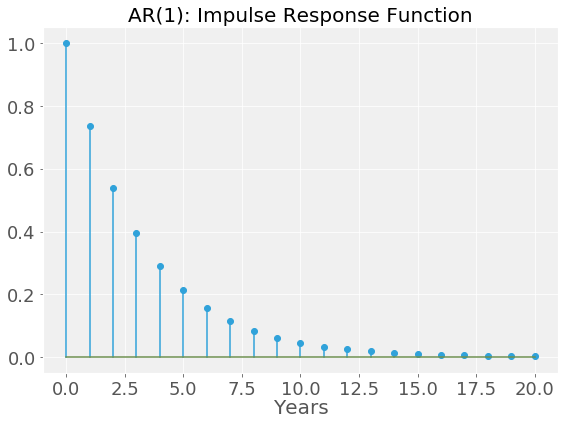

In [58]:
ar1_irf = impulse_response_func(beta_hat_ar1, include_const=True)

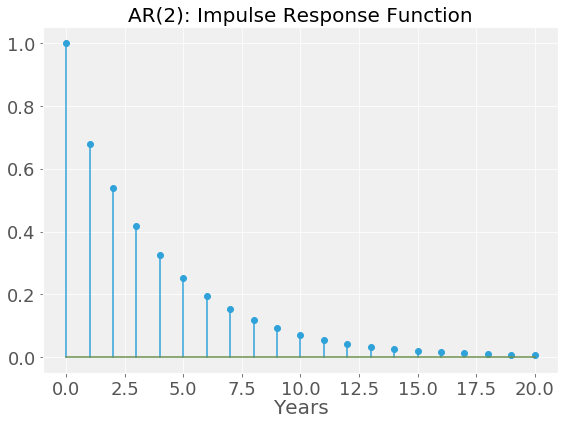

In [59]:
ar2_irf = impulse_response_func(beta_hat_ar2, include_const=True)

### Step G: Compare both models using the criterion discussed in class. Which model do you prefer?

**Solution:** Given the battery of diagnostics, the AR($1$) model is the preferred one!

## Exercise 9 :

Let's check if the S&P 500 P/E ratio is stationary or not. Even though both our AR($1$) and AR($2$) models yielded no unit roots, we will start by differencing and analyzing the *ACF*/*PACF*:

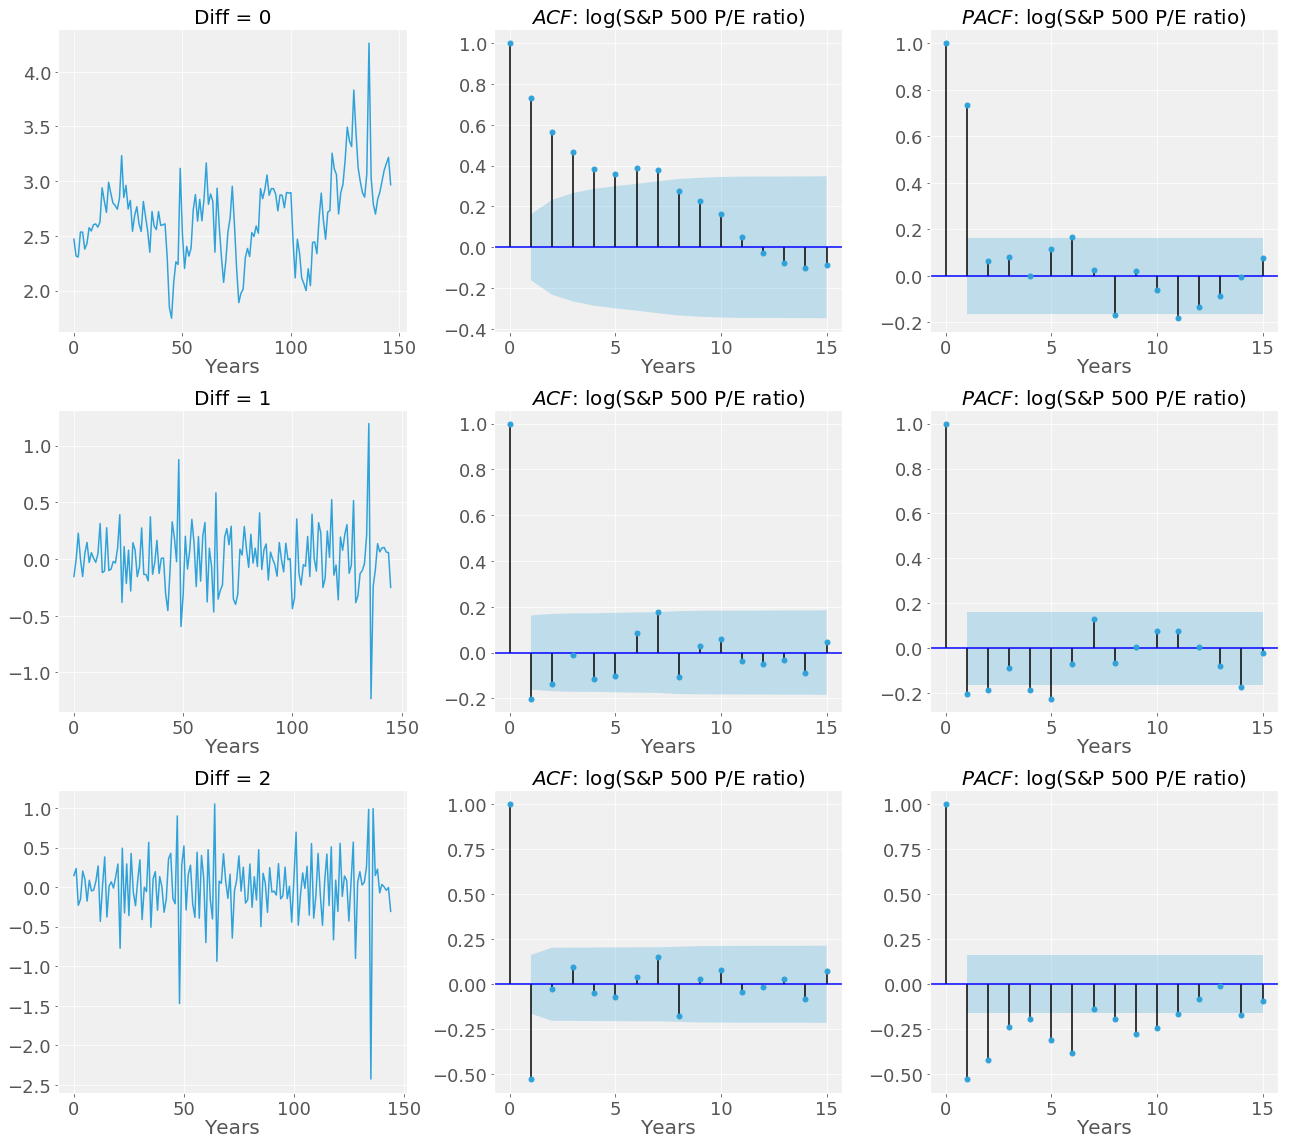

In [60]:
log_sp500_pe = dfquandl['Log']
nlags = 15

### First plot the raw and differenced data, and then the ACF/PACF
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,16))
for d in range(3):
    if d==0:
        Dysim = np.copy(log_sp500_pe)
        axes[d,0].plot(Dysim)
        axes[d,0].set_xlabel('Years', fontsize=20)
    else:
        Dysim = Dysim[1:] - Dysim[:-1]
        axes[d,0].plot(Dysim[:250]) 
        axes[d,0].set_xlabel('Years', fontsize=20)
    
    axes[d,0].set_title('Diff = %d'% d, fontsize=20)
    
    ### ACF/PACF
    plot_acf(x=Dysim,  ax=axes[d,1], lags=nlags)
    plot_pacf(x=Dysim, ax=axes[d,2], lags=nlags)
    axes[d,1].set_title("${\it ACF}$: log(S&P 500 P/E ratio)", fontsize=20)
    axes[d,2].set_title("${\it PACF}$: log(S&P 500 P/E ratio)", fontsize=20)
    axes[d,1].set_xlabel('Years', fontsize=20)
    axes[d,2].set_xlabel('Years', fontsize=20)

fig.tight_layout()

It appears that this time series process is potentially $I(0)$ or $I(1)$. 

The *ACF* and *PACF* may also suggest the log of the S&P 500 P/E ratio follows an ARIMA($0$,$1$,$1$), but it looks like it will be an AR($1$)!


Let's run some formal unit root tests. Specifically, let's run the **Augmented Dickey-Fuller** test with up to 5 lags:

In [61]:
def adf_test(y, nlags):
    """
    Augmented Dickey-Fuller test with p-values obtained through 
    regression surface approximation from MacKinnon [1994], similar to 
    the statsmodels routine: statsmodels.tsa.stattools.adfuller
    """
    diff_z = np.diff(y, axis=0)
    z = y[:-1]  
    ols_results, _ = calc_ols(diff_z, z)
    df_stat = ols_results['t-stat'][1]
    p_value = mackinnonp(df_stat, regression='c', N=1)
    cr_val = mackinnoncrit(N=1, regression='c', nobs=len(y))
    print('(A)DF critical values |  1%: {:.3f},  5%:{:.3f},  10%:{:.3f}'.format(cr_val[0], cr_val[1], cr_val[2]))
    print('df test, (no lags)    |  df-stat: {:.3f},  p-value: {:.3f}'.format(df_stat, p_value))
    
    for i in range(1, nlags + 1):       
        z = np.column_stack((z[1:], diff_z[:-i]))
        ols_results, _ = calc_ols(diff_z[i:], z)
        adf_stat = ols_results['t-stat'][1]
        p_value = mackinnonp(adf_stat, regression='c', N=1)
        print('ADF test, lag# = '+ str(i),'   | ADF-stat: {:.3f},  p-value: {:.3f}'.format(adf_stat, p_value))        


In [62]:
### Augmented Dickey-Fuller test: "brute-force"
# ADF Test
adf_test(log_sp500_pe, nlags=5)

(A)DF critical values |  1%: -3.476,  5%:-2.881,  10%:-2.577
df test, (no lags)    |  df-stat: -4.695,  p-value: 0.000
ADF test, lag# = 1    | ADF-stat: -4.045,  p-value: 0.001
ADF test, lag# = 2    | ADF-stat: -3.490,  p-value: 0.008
ADF test, lag# = 3    | ADF-stat: -3.261,  p-value: 0.017
ADF test, lag# = 4    | ADF-stat: -2.763,  p-value: 0.064
ADF test, lag# = 5    | ADF-stat: -2.264,  p-value: 0.184


According to both the **Dickey-Fuller** and **Augmented Dickey-Fuller** tests, at the $5/%$ significance level, we can reject the null hypothesis of a unit root since the test-statistics are all larger than the critical values for $lags=0,1,2,...,5$.

Hence, there **we reject the null hypothesis of a unit root** in the log of the S&P 500 P/E ratio.

The next step would be to consider various AR($p$) models for stationary specifications using various information criteria. 

Though by looking at the *BIC* and *AIC* values for both the AR($1$) and AR($2$) models, the AR($1$) model has both a lower *BIC* and *AIC* in comparison to the AR($2$) model, potentially suggesting the AR($1$) model fits the best. But, we can still look at model selection via information criteria:

## Exercise 10:

Let's consider various AR($p$) models for $p=1,2,3,4,5$ and analyze the relevant information criteria:

In [66]:
### Create data for OLS regressions: AR(3), AR(4), AR(5):
dfquandl['Log_lag3'] = dfquandl['Log_lag2'].shift(1)
dfquandl['Log_lag4'] = dfquandl['Log_lag3'].shift(1)
dfquandl['Log_lag5'] = dfquandl['Log_lag4'].shift(1)
dfquandl = dfquandl.dropna() # drop missings
y_lhs = dfquandl['Log']  

In [68]:
ic = ['AIC', 'BIC', 'Hannan-Quinn', '$R^2$', 'adjusted-$R^2$']
for p in [1, 2, 3, 4, 5]:
    col_label = 'Log_lag' + str(p)
    if p==1:
        x_rhs = dfquandl[[col_label]]
        _, arp_stats = calc_ols(y_lhs, x_rhs, addcon=True)
        ic_p = [arp_stats[s] for s in ic if s in arp_stats] 
        df_ic = pd.DataFrame(np.array(ic_p), index=ic, columns=['lag='+ str(p)])
    else:
        x_rhs = x_rhs.merge(dfquandl[[col_label]], how='inner', left_index=True, right_index=True)
        _, arp_stats = calc_ols(y_lhs, x_rhs, addcon=True)
        
        ic_p = [arp_stats[s] for s in ic if s in arp_stats] 
        df_ic_p = pd.DataFrame(np.array(ic_p), index=ic, columns=['lag='+ str(p)])
        df_ic = df_ic.merge(df_ic_p, how='inner', left_index=True, right_index=True)

### Information criteria: AIC, BIC, Hannan-Quinn, R-squared, adjusted R-squared
df_ic

,lag=1,lag=2,lag=3,lag=4,lag=5
AIC,20.117,21.305,22.386,24.385,24.568
BIC,26.018,30.154,34.184,39.133,42.264
Hannan-Quinn,0.137,0.154,0.170,0.193,0.203
$R^2$,0.533,0.536,0.539,0.539,0.545
adjusted-$R^2$,0.530,0.529,0.529,0.525,0.528


To be fully comprehensive, we should also consider a model that only uses the unconditional mean to explain the dependent variable (i.e. a $lag=0$ model). For now, it is very clear that for the *AIC*, *BIC*, and *Hannan-Quinn* information criteria, the AR($1$) model performs the best!

That is all for today! 😎